# Adsorption

In [1]:
import sys, os
import glob
import numpy as np
import xarray as xr
from simtk import unit

import thermoextrap

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from thermoextrap.gpr_active import active_utils
from thermoextrap.gpr_active import gp_models

## Preliminaries

In [2]:
from run_active_adsorption import *

<IPython.core.display.Javascript object>


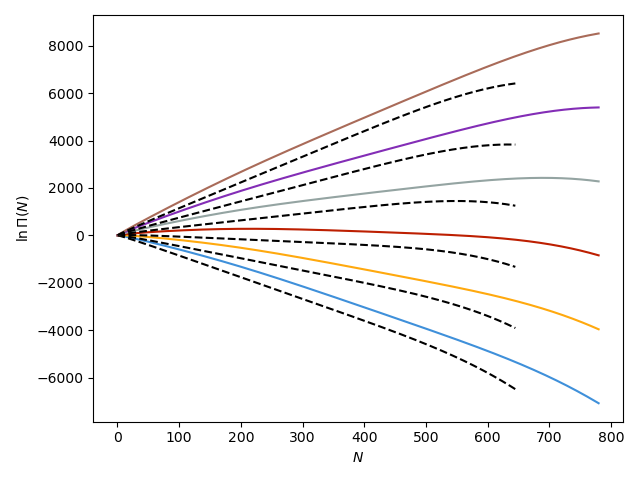

With mu=3.900000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.000000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.100000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.200000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.300000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.400000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.500000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.600000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.700000, have at least one replicate with maximum less than 10 from end of N range simulated.
With mu=4.800000, have at least one replicate with maximum less than 10 f

In [3]:
%matplotlib notebook

#Plot lnPi curves, both inside pore and in bulk
fig, ax = plt.subplots()

#But also need to figure out range of mu values to work with...
#Should stop when maximum is less than 10 bins from end, at which point density is not accurate

for m in np.arange(-15, 11, 0.1):
    Nbulk, lnPibulk = get_lnPi(m, file_str=os.path.expanduser('~/GPR_Extrapolation/Adsorption/sw_t125/t125.v729.b.lnpi.dat'))
    N, lnPi = get_lnPi(m)
    
    maxims = np.argmax((lnPi.T-lnPi[:, 0]), axis=0)
    maxNs = [N[k, maxims[k]] for k in range(N.shape[0])]
    endNs = N[:, -1]
    if np.any(maxNs > (endNs-10)):
        print('With mu=%f, have at least one replicate with maximum less than 10 from end of N range simulated.'%m)
        
    if np.around(m, 4)%5 == 0.0:
        ax.plot(N.T[:, 0], (lnPi.T-lnPi[:, 0])[:, 0], label='%f'%m)
        ax.plot(Nbulk.T, lnPibulk.T-lnPibulk[:, 0], 'k--')

ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\ln \Pi (N)$')

#ax.legend()

fig.tight_layout()

plt.show()

In [4]:
print(N.shape)

(3, 781)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


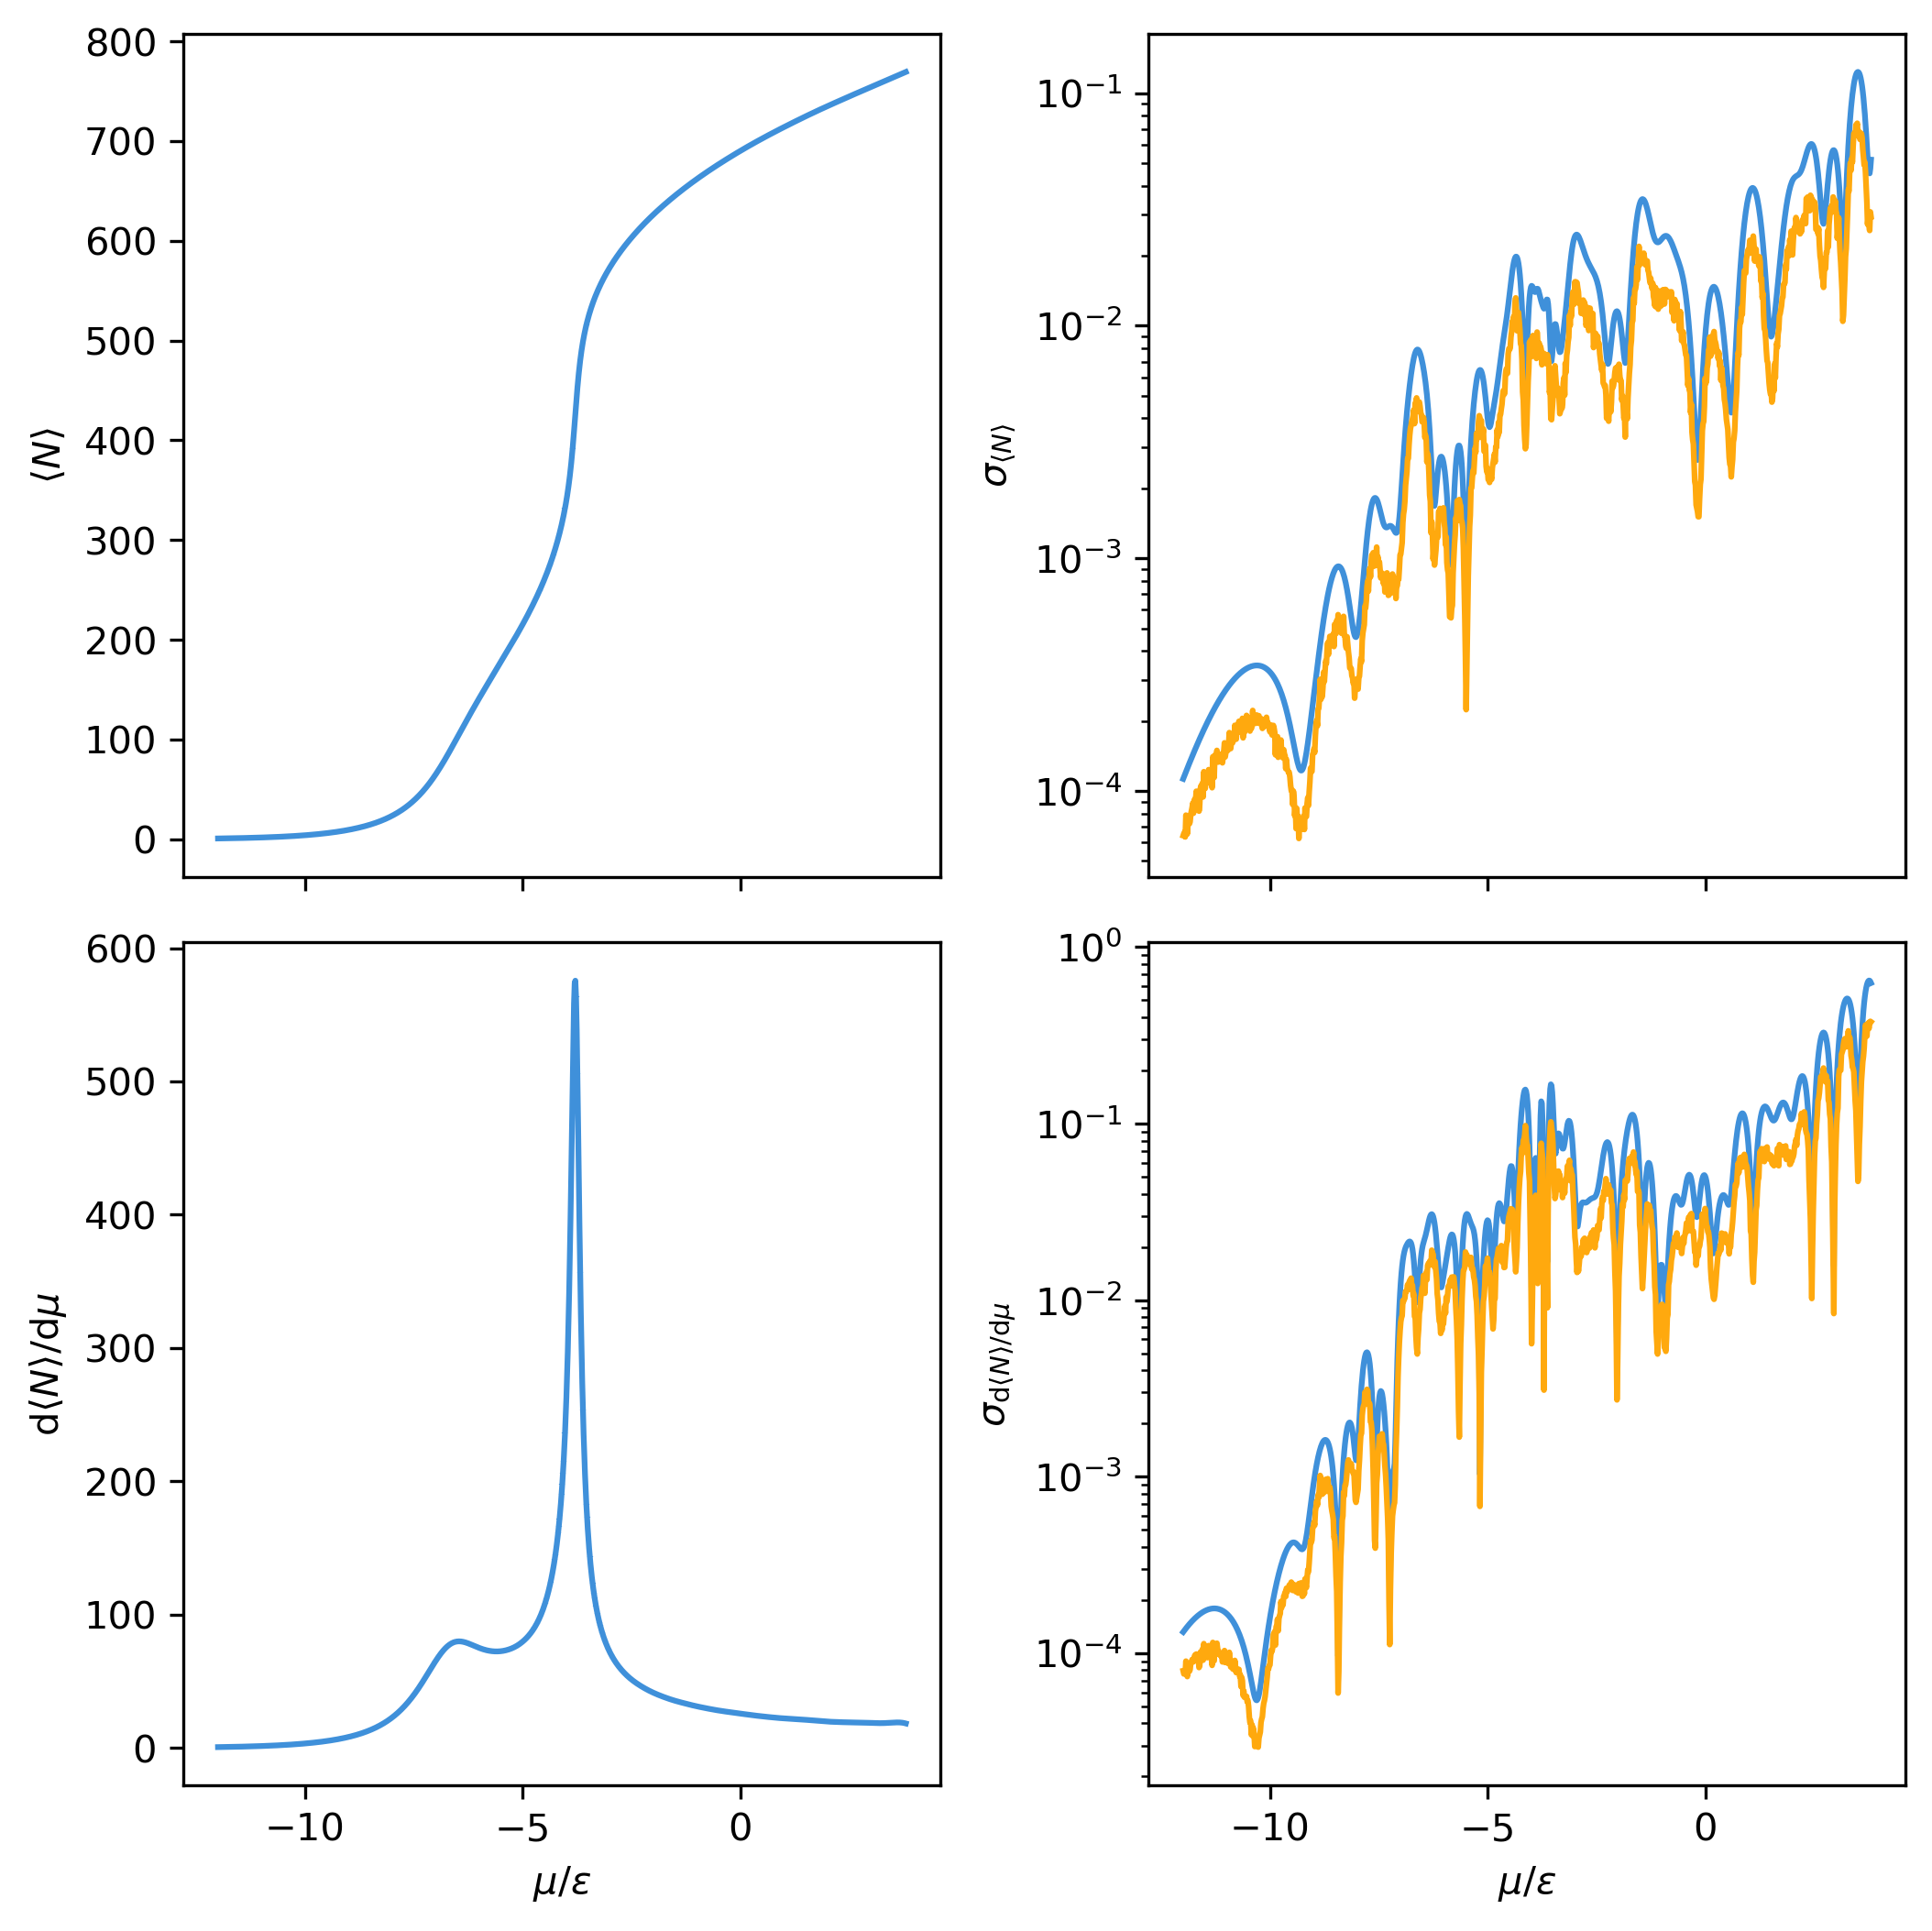

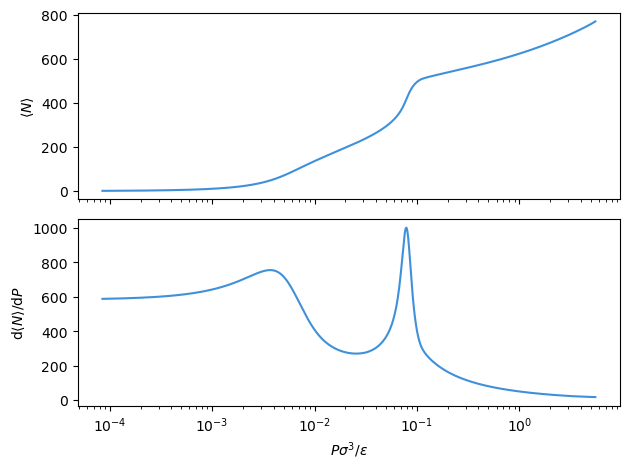

In [5]:
%matplotlib inline

#To look at convergence, compute absorption curves with uncertainties at many mu values
mu_plot = np.linspace(-12.0, 3.8, 1000)
P_plot = np.array([get_bulk_P(m) for m in mu_plot])
ads_vals = np.zeros((mu_plot.shape[0], 3))
ads_derivs = np.zeros((mu_plot.shape[0], 3))

for i, m in enumerate(mu_plot):
    this_dat = SimulateAdsorption().run_sim(None, m)
    this_coefs = this_dat.build_state(max_order=1).derivs(norm=False)
    this_means = this_coefs.mean('rec').values
    this_stds = np.sqrt(this_coefs.var('rec').values)
    resamp_stds = np.sqrt(this_dat.build_state(max_order=1).resample(nrep=100).derivs(norm=False).var('rep').values)
    ads_vals[i, 0] = this_means[0, 0]
    ads_vals[i, 1] = this_stds[0, 0]
    ads_vals[i, 2] = resamp_stds[0, 0]
    ads_derivs[i, 0] = this_means[1, 0]
    ads_derivs[i, 1] = this_stds[1, 0]
    ads_derivs[i, 2] = resamp_stds[1, 0]
    
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(7.13, 7.13), dpi=300)

ax[0, 0].errorbar(mu_plot, ads_vals[:, 0], yerr=ads_vals[:, 1])
ax[1, 0].errorbar(mu_plot, ads_derivs[:, 0], yerr=ads_derivs[:, 1])

ax[0, 1].plot(mu_plot, ads_vals[:, 1])
ax[1, 1].plot(mu_plot, ads_derivs[:, 1])

ax[0, 1].plot(mu_plot, ads_vals[:, 2])
ax[1, 1].plot(mu_plot, ads_derivs[:, 2])

ax[0, 0].set_ylabel(r'$\langle N \rangle$')
ax[1, 0].set_ylabel(r'$\mathrm{d}\langle N \rangle / \mathrm{d} \mu$')
ax[1, 0].set_xlabel(r'$\mu / \epsilon$')

ax[0, 1].set_ylabel(r'$\sigma_{\langle N \rangle}$')
ax[1, 1].set_ylabel(r'$\sigma_{\mathrm{d}\langle N \rangle / \mathrm{d} \mu}$')
ax[1, 1].set_xlabel(r'$\mu / \epsilon$')

ax[0, 1].set_yscale('log')
ax[1, 1].set_yscale('log')

fig.tight_layout()

pfig, pax = plt.subplots(2, sharex=True, sharey=False)
pax[0].plot(P_plot, ads_vals[:, 0])
pax[1].plot(P_plot, ads_derivs[:, 0]*729.0/ads_vals[:, 0])
pax[1].set_xscale('log')

pax[0].set_ylabel(r'$\langle N \rangle$')
pax[1].set_ylabel(r'$\mathrm{d}\langle N \rangle / \mathrm{d} P$')
pax[1].set_xlabel(r'$P \sigma^3 / \epsilon$')

pfig.tight_layout()

plt.show()

In [6]:
from scipy import interpolate

#Create a function we can use as the ground truth to compare to
ground_truth_ads = interpolate.interp1d(mu_plot, ads_vals[:, 0], kind='cubic')

## Active Learning Comparisons

We will compare a number of stopping criteria across three different update schemes and examine the convergence behavior. Specifically, we want to compare how quickly different stopping criteria converge for each update procedure (ALM, random, or space-filling). We also want to compare the dependence of the model parameters and stopping criteria values on the way that the data is selected. Ideally, the parameters and stopping criteria will all converge to the same values with enough data points, regardless of the update strategy.

In [7]:
%matplotlib inline

#Identify directory where data is held
base_dir = os.path.expanduser('~/GPR_Extrapolation/Adsorption')

#And all run directories
run_dirs = glob.glob('%s/run*'%base_dir)
run_dirs.sort()
print(run_dirs)

['/Users/jim2/GPR_Extrapolation/Adsorption/run1', '/Users/jim2/GPR_Extrapolation/Adsorption/run10', '/Users/jim2/GPR_Extrapolation/Adsorption/run11', '/Users/jim2/GPR_Extrapolation/Adsorption/run12', '/Users/jim2/GPR_Extrapolation/Adsorption/run13', '/Users/jim2/GPR_Extrapolation/Adsorption/run14', '/Users/jim2/GPR_Extrapolation/Adsorption/run15', '/Users/jim2/GPR_Extrapolation/Adsorption/run16', '/Users/jim2/GPR_Extrapolation/Adsorption/run17', '/Users/jim2/GPR_Extrapolation/Adsorption/run18', '/Users/jim2/GPR_Extrapolation/Adsorption/run19', '/Users/jim2/GPR_Extrapolation/Adsorption/run2', '/Users/jim2/GPR_Extrapolation/Adsorption/run20', '/Users/jim2/GPR_Extrapolation/Adsorption/run21', '/Users/jim2/GPR_Extrapolation/Adsorption/run22', '/Users/jim2/GPR_Extrapolation/Adsorption/run23', '/Users/jim2/GPR_Extrapolation/Adsorption/run24', '/Users/jim2/GPR_Extrapolation/Adsorption/run25', '/Users/jim2/GPR_Extrapolation/Adsorption/run26', '/Users/jim2/GPR_Extrapolation/Adsorption/run27', '

### Maximum variance active learning

In [10]:
#Collect training information
train_info_alm = []
for rdir in run_dirs[:8]:
    try:
        train_info_alm.append(np.load('%s/alm/active_history.npz'%rdir))
    except IOError:
        print("File not found in directory %s"%rdir)

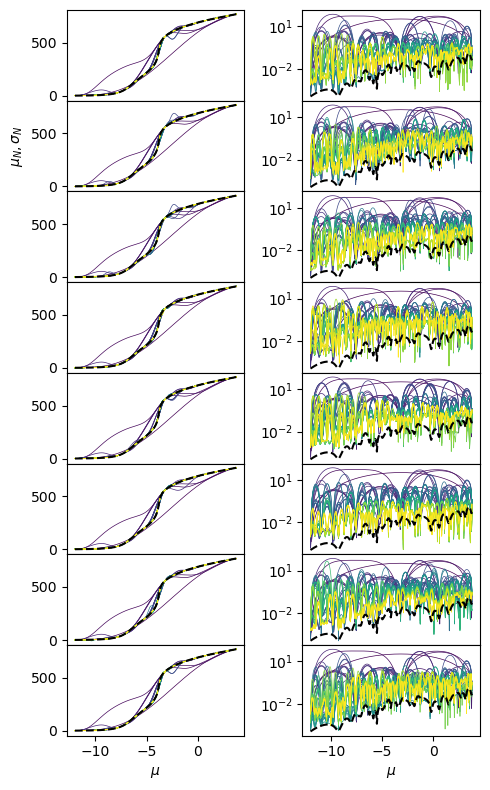

In [11]:
#Plot curves over each iteration for each run
#With uncertainty in second column
fig, ax = plt.subplots(len(train_info_alm), 2, sharex=True, sharey='col', figsize=(5.0, 1.0*len(train_info_alm)))

for i, t_info in enumerate(train_info_alm):
    this_means = t_info['pred_mu']
    this_stds = t_info['pred_std']
    this_alphas = t_info['alpha']
    this_alpha_grid = np.linspace(t_info['alpha'].min(), t_info['alpha'].max(), this_means.shape[1])
    this_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_means.shape[0]))
    for j in range(this_means.shape[0]):
        ax[i, 0].plot(this_alpha_grid, this_means[j, :], color=this_colors[j], linewidth=0.5)
        ax[i, 1].plot(this_alpha_grid, this_stds[j, :], color=this_colors[j], linewidth=0.5)
    ax[i, 0].plot(mu_plot, ads_vals[:, 0], 'k--')
    ax[i, 1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1, 0].set_xlabel(r'$\mu$')
ax[-1, 1].set_xlabel(r'$\mu$')
ax[1, 0].set_ylabel(r'$\mu_N , \sigma_N$')

ax[0, 1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

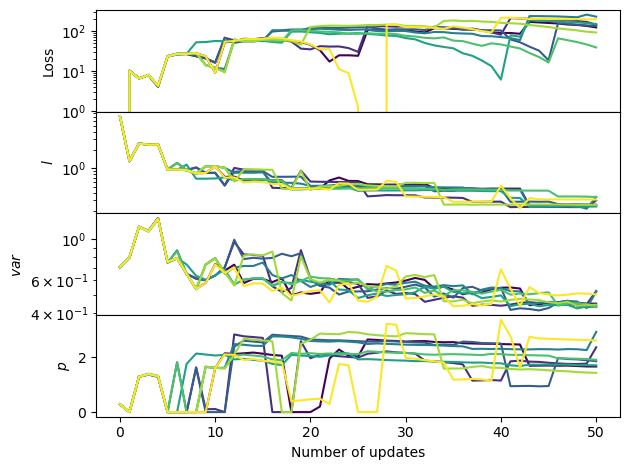

In [12]:
#Plot model parameters and loss over update iterations
fig, ax = plt.subplots(4, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_alm)))

for i, t_info in enumerate(train_info_alm):
    ax[0].plot(t_info['loss'], color=run_colors[i])
    this_params = t_info['params']
    for j in range(this_params.shape[1]):
        ax[j+1].plot(this_params[:, j], color=run_colors[i])

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'Loss')
ax[1].set_ylabel(r'$l$')
ax[2].set_ylabel(r'$var$')
ax[3].set_ylabel(r'$p$')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

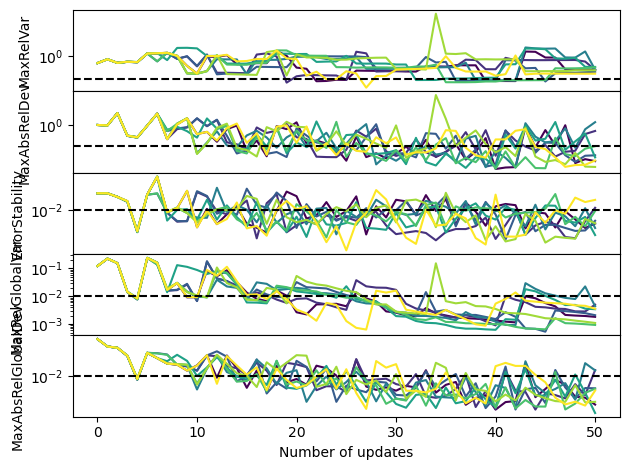

In [13]:
#Plot stopping criteria metrics over update iterations
fig, ax = plt.subplots(5, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_alm)))

for i, t_info in enumerate(train_info_alm):
    ax[0].plot(t_info['MaxRelVar'], color=run_colors[i])
    ax[1].plot(t_info['MaxAbsRelDev'], color=run_colors[i])
    ax[2].plot(t_info['ErrorStability'], color=run_colors[i])
    ax[3].plot(t_info['MaxRelGlobalVar'], color=run_colors[i])
    ax[4].plot(t_info['MaxAbsRelGlobalDeviation'], color=run_colors[i])

for a in ax:
    a.axhline(1e-02, color='k', linestyle='--')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'MaxRelVar')
ax[1].set_ylabel(r'MaxAbsRelDev')
ax[2].set_ylabel(r'ErrorStability')
ax[3].set_ylabel(r'MaxRelGlobalVar')
ax[4].set_ylabel(r'MaxAbsRelGlobalDev')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Random

In [14]:
#Collect training information
train_info_rand = []
for rdir in run_dirs[:8]:
    try:
        train_info_rand.append(np.load('%s/random/active_history.npz'%rdir))
    except IOError:
        print("File not found in directory %s"%rdir)

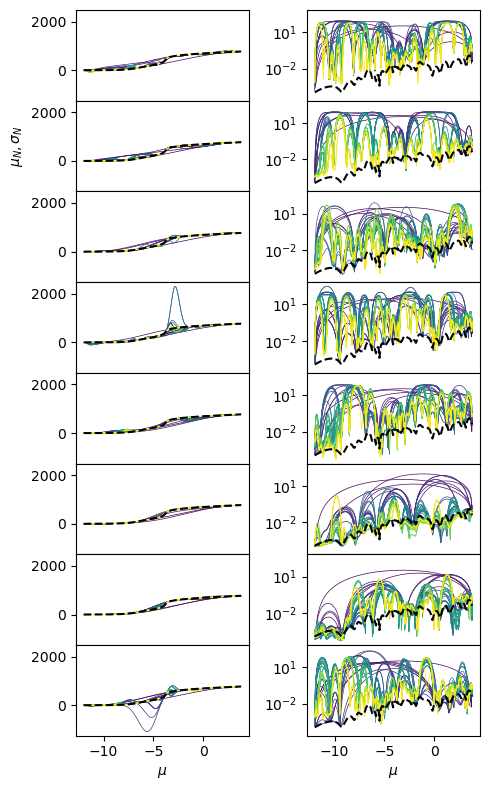

In [15]:
#Plot curves over each iteration for each run
#With uncertainty in second column
fig, ax = plt.subplots(len(train_info_rand), 2, sharex=True, sharey='col', figsize=(5.0, 1.0*len(train_info_rand)))

for i, t_info in enumerate(train_info_rand):
    this_means = t_info['pred_mu']
    this_stds = t_info['pred_std']
    this_alphas = t_info['alpha']
    this_alpha_grid = np.linspace(t_info['alpha'].min(), t_info['alpha'].max(), this_means.shape[1])
    this_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_means.shape[0]))
    for j in range(this_means.shape[0]):
        ax[i, 0].plot(this_alpha_grid, this_means[j, :], color=this_colors[j], linewidth=0.5)
        ax[i, 1].plot(this_alpha_grid, this_stds[j, :], color=this_colors[j], linewidth=0.5)
    ax[i, 0].plot(mu_plot, ads_vals[:, 0], 'k--')
    ax[i, 1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1, 0].set_xlabel(r'$\mu$')
ax[-1, 1].set_xlabel(r'$\mu$')
ax[1, 0].set_ylabel(r'$\mu_N , \sigma_N$')

ax[0, 1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

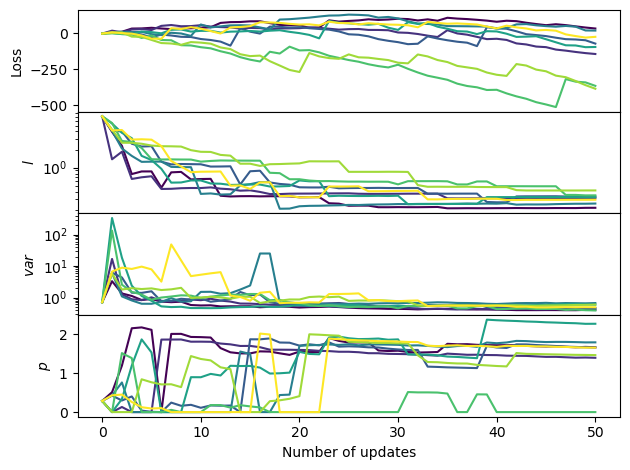

In [16]:
#Plot model parameters and loss over update iterations
fig, ax = plt.subplots(4, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_rand)))

for i, t_info in enumerate(train_info_rand):
    ax[0].plot(t_info['loss'], color=run_colors[i])
    this_params = t_info['params']
    for j in range(this_params.shape[1]):
        ax[j+1].plot(this_params[:, j], color=run_colors[i])

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'Loss')
ax[1].set_ylabel(r'$l$')
ax[2].set_ylabel(r'$var$')
ax[3].set_ylabel(r'$p$')

# ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

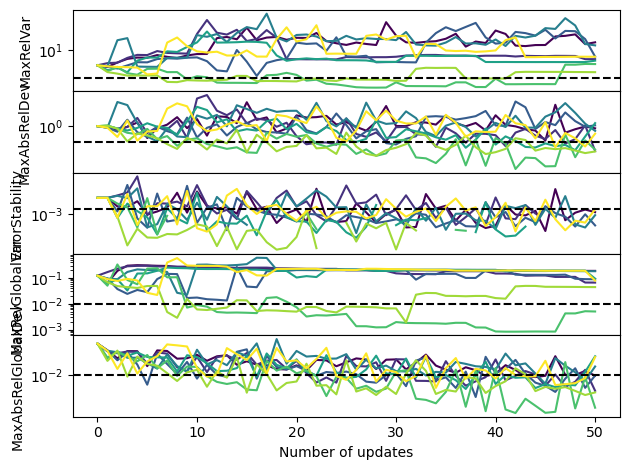

In [17]:
#Plot stopping criteria metrics over update iterations
fig, ax = plt.subplots(5, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_rand)))

for i, t_info in enumerate(train_info_rand):
    ax[0].plot(t_info['MaxRelVar'], color=run_colors[i])
    ax[1].plot(t_info['MaxAbsRelDev'], color=run_colors[i])
    ax[2].plot(t_info['ErrorStability'], color=run_colors[i])
    ax[3].plot(t_info['MaxRelGlobalVar'], color=run_colors[i])
    ax[4].plot(t_info['MaxAbsRelGlobalDeviation'], color=run_colors[i])

for a in ax:
    a.axhline(1e-02, color='k', linestyle='--')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'MaxRelVar')
ax[1].set_ylabel(r'MaxAbsRelDev')
ax[2].set_ylabel(r'ErrorStability')
ax[3].set_ylabel(r'MaxRelGlobalVar')
ax[4].set_ylabel(r'MaxAbsRelGlobalDev')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Space-filling active learning

In [18]:
#Collect training information
train_info_space = []
for rdir in run_dirs[:8]:
    try:
        train_info_space.append(np.load('%s/space_fill/active_history.npz'%rdir))
    except IOError:
        print("File not found in directory %s"%rdir)

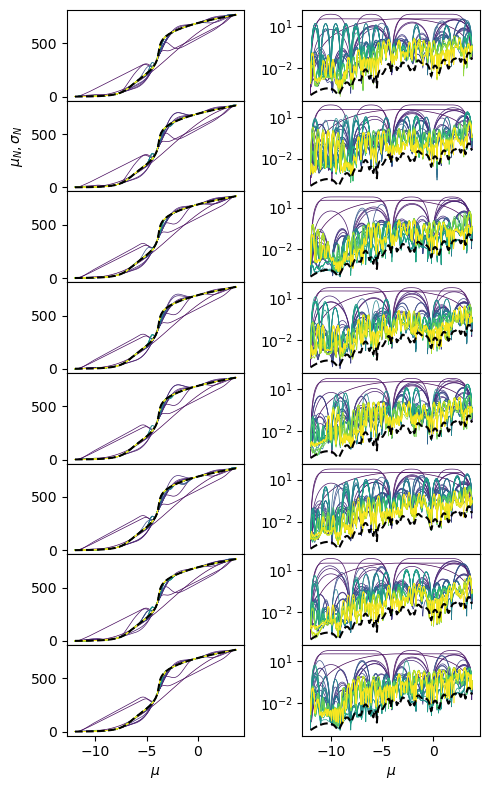

In [19]:
#Plot curves over each iteration for each run
#With uncertainty in second column
fig, ax = plt.subplots(len(train_info_space), 2, sharex=True, sharey='col', figsize=(5.0, 1.0*len(train_info_space)))

for i, t_info in enumerate(train_info_space):
    this_means = t_info['pred_mu']
    this_stds = t_info['pred_std']
    this_alphas = t_info['alpha']
    this_alpha_grid = np.linspace(t_info['alpha'].min(), t_info['alpha'].max(), this_means.shape[1])
    this_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_means.shape[0]))
    for j in range(this_means.shape[0]):
        ax[i, 0].plot(this_alpha_grid, this_means[j, :], color=this_colors[j], linewidth=0.5)
        ax[i, 1].plot(this_alpha_grid, this_stds[j, :], color=this_colors[j], linewidth=0.5)
    ax[i, 0].plot(mu_plot, ads_vals[:, 0], 'k--')
    ax[i, 1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1, 0].set_xlabel(r'$\mu$')
ax[-1, 1].set_xlabel(r'$\mu$')
ax[1, 0].set_ylabel(r'$\mu_N , \sigma_N$')

ax[0, 1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

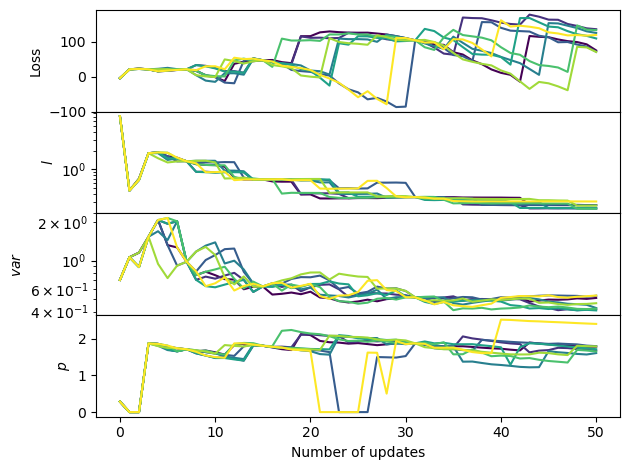

In [20]:
#Plot model parameters and loss over update iterations
fig, ax = plt.subplots(4, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_space)))

for i, t_info in enumerate(train_info_space):
    ax[0].plot(t_info['loss'], color=run_colors[i])
    this_params = t_info['params']
    for j in range(this_params.shape[1]):
        ax[j+1].plot(this_params[:, j], color=run_colors[i])

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'Loss')
ax[1].set_ylabel(r'$l$')
ax[2].set_ylabel(r'$var$')
ax[3].set_ylabel(r'$p$')

# ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

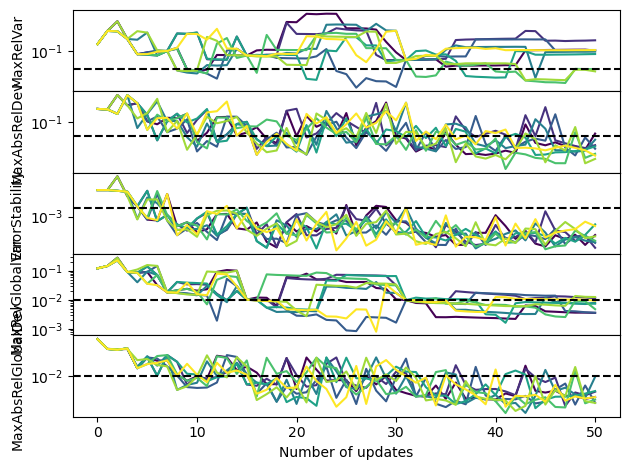

In [21]:
#Plot stopping criteria metrics over update iterations
fig, ax = plt.subplots(5, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_space)))

for i, t_info in enumerate(train_info_space):
    ax[0].plot(t_info['MaxRelVar'], color=run_colors[i])
    ax[1].plot(t_info['MaxAbsRelDev'], color=run_colors[i])
    ax[2].plot(t_info['ErrorStability'], color=run_colors[i])
    ax[3].plot(t_info['MaxRelGlobalVar'], color=run_colors[i])
    ax[4].plot(t_info['MaxAbsRelGlobalDeviation'], color=run_colors[i])

for a in ax:
    a.axhline(1e-02, color='k', linestyle='--')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'MaxRelVar')
ax[1].set_ylabel(r'MaxAbsRelDev')
ax[2].set_ylabel(r'ErrorStability')
ax[3].set_ylabel(r'MaxRelGlobalVar')
ax[4].set_ylabel(r'MaxAbsRelGlobalDev')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Comparison active learning

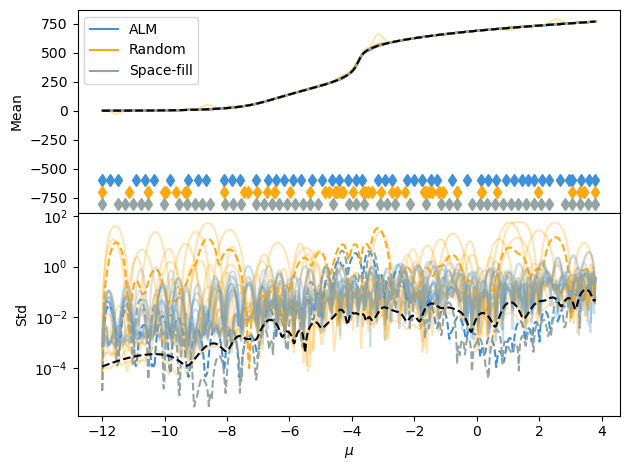

In [24]:
#All final models (values, not derivatives)
fig, ax = plt.subplots(2, sharex=True)

train_colors = ["#3f90da", "#ffa90e", "#94a4a2"]
train_labels = ['ALM', 'Random', 'Space-fill']

for i, t_info_list in enumerate([train_info_alm, train_info_rand, train_info_space]):
    this_mu = np.array([t_info['pred_mu'][-1, :] for t_info in t_info_list])
    this_avg_mu = np.average(this_mu, axis=0)
    this_std_mu = np.std(this_mu, axis=0)
    this_std = np.array([t_info['pred_std'][-1, :] for t_info in t_info_list])
    this_alpha = t_info_list[0]['alpha']
    this_alpha_grid = np.linspace(this_alpha.min(), this_alpha.max(), this_mu.shape[1])
    ax[0].plot(this_alpha_grid, this_avg_mu, color=train_colors[i], label=train_labels[i])
    ax[1].plot(this_alpha_grid, this_std_mu, color=train_colors[i], linestyle='--')
    ax[0].plot(this_alpha_grid, this_mu.T[0], color=train_colors[i], alpha=0.3)
    ax[1].plot(this_alpha_grid, this_std.T[0], color=train_colors[i], alpha=0.3)
    
    ax[0].plot(this_alpha, (-600-i*100)*np.ones_like(this_alpha),
               marker='d', color=train_colors[i], linestyle='')

ax[0].legend()

ax[0].plot(mu_plot, ads_vals[:, 0], 'k--')
ax[1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1].set_xlabel(r'$\mu$')

ax[0].set_ylabel(r'Mean')
ax[1].set_ylabel(r'Std')

ax[1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

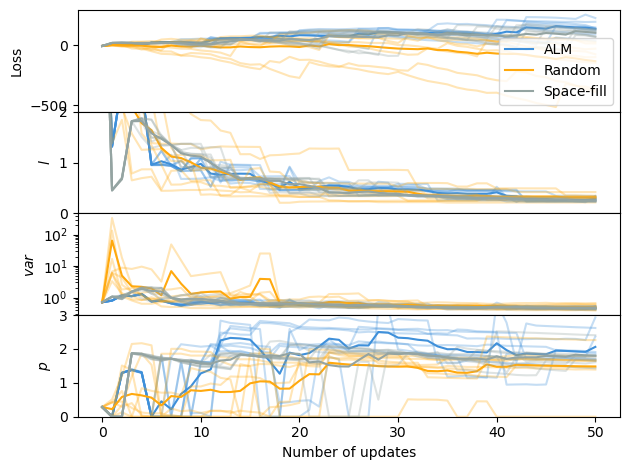

In [25]:
#Comparing losses and parameters
fig, ax = plt.subplots(4, sharex=True, sharey=False)

train_colors = ["#3f90da", "#ffa90e", "#94a4a2"]
train_labels = ['ALM', 'Random', 'Space-fill']

for i, t_info_list in enumerate([train_info_alm, train_info_rand, train_info_space]):
    this_loss = np.array([t_info['loss'] for t_info in t_info_list])
    this_avg_loss = np.average(this_loss, axis=0)
    this_std_loss = np.std(this_loss, axis=0)
    ax[0].plot(this_avg_loss, color=train_colors[i], label=train_labels[i])
    ax[0].plot(this_loss.T, color=train_colors[i], alpha=0.3)
#     ax[0].fill_between(np.arange(this_avg_loss.shape[0]),
#                        this_avg_loss-2.0*this_std_loss,
#                        this_avg_loss+2.0*this_std_loss,
#                        color=train_colors[i], alpha=0.3)
    this_params = np.array([t_info['params'] for t_info in t_info_list])
    for j in range(this_params.shape[-1]):
        this_avg_param = np.average(this_params[:, :, j], axis=0)
        this_std_param = np.std(this_params[:, :, j], axis=0)
        ax[j+1].plot(this_avg_param, color=train_colors[i])
        ax[j+1].plot(this_params[:, :, j].T, color=train_colors[i], alpha=0.3)
#         ax[j+1].fill_between(np.arange(this_avg_param.shape[0]),
#                              this_avg_param-2.0*this_std_param,
#                              this_avg_param+2.0*this_std_param,
#                              color=train_colors[i], alpha=0.3)

ax[0].legend()

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'Loss')
ax[1].set_ylabel(r'$l$')
ax[2].set_ylabel(r'$var$')
ax[3].set_ylabel(r'$p$')

# ax[0].set_yscale('log')
# ax[0].set_ylim((1e-01, 2e+03))
ax[1].set_ylim((0.0, 2.0))
ax[2].set_yscale('log')
# ax[2].set_ylim((1e+0, 1e+03))
ax[3].set_ylim((0.0, 3.0))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

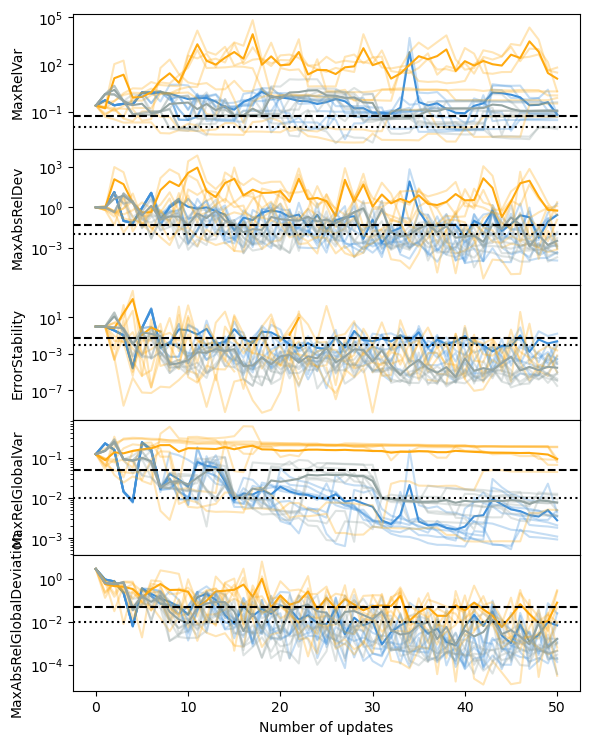

In [26]:
#Plot stopping criteria metrics over update iterations
metric_names = ['MaxRelVar', 'MaxAbsRelDev', 'ErrorStability', 'MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

fig, ax = plt.subplots(len(metric_names), sharex=True, sharey=False, figsize=(6, 1.5*len(metric_names)))

train_colors = ["#3f90da", "#ffa90e", "#94a4a2"]
train_labels = ['ALM', 'Random', 'Space-fill']

for i, t_info_list in enumerate([train_info_alm, train_info_rand, train_info_space]):
    for j, key in enumerate(metric_names):
        this_metric = np.array([t_info[key] for t_info in t_info_list])
        this_avg_metric = np.average(this_metric, axis=0)
        this_std_metric = np.std(this_metric, axis=0)
        ax[j].plot(this_avg_metric, color=train_colors[i], label=train_labels[i])
        ax[j].plot(this_metric.T, color=train_colors[i], alpha=0.3)

for a in ax:
    a.axhline(5e-02, color='k', linestyle='--')
    a.axhline(1e-02, color='k', linestyle=':')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
for j, key in enumerate(metric_names):
    ax[j].set_ylabel(key)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

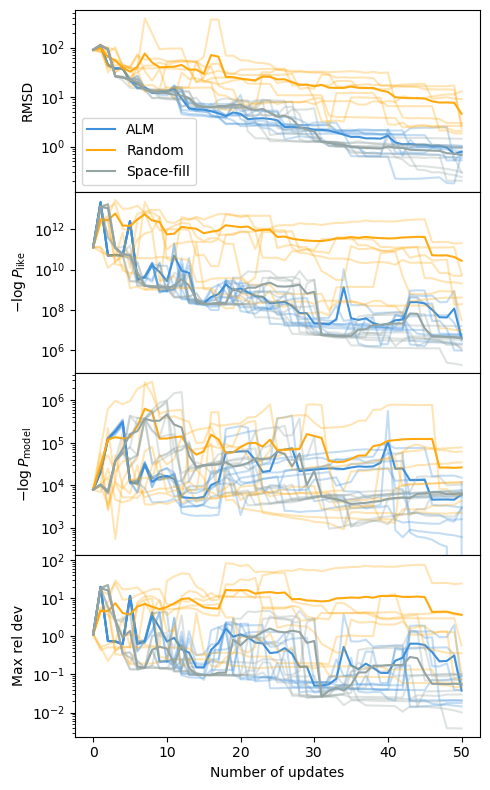

In [36]:
#Real test is distance from ground truth
#Have intentionally set mu_plot so that will be same as values used to evaluate GP models in training histories
#So can compare distance to ground truth versus update iteration
fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(5.0, 2.0*4))

train_colors = ["#3f90da", "#ffa90e", "#94a4a2"]
train_labels = ['ALM', 'Random', 'Space-fill']

for i, t_info_list in enumerate([train_info_alm, train_info_rand, train_info_space]):
    this_mean = np.array([t_info['pred_mu'][..., 0] for t_info in t_info_list])
    this_std = np.array([t_info['pred_std'][..., 0] for t_info in t_info_list])
    this_rmsd = np.sqrt(np.average((this_mean - ads_vals[:, 0])**2, axis=-1))
    this_gt_logprob = np.sum(0.5*((this_mean - ads_vals[:, 0])/ads_vals[:, 1])**2 + np.log(ads_vals[:, 1]), axis=-1)
    #Below log probability is not strictly correct... under posterior, model predictions NOT independent
    #So need full covariance, but not saved as part of history and do not have data list, either, to rebuild GP
    this_model_logprob = np.sum(0.5*((ads_vals[:, 0] - this_mean)/this_std)**2 + np.log(this_std), axis=-1)
    this_max_rel_dev = np.max(abs(this_mean - ads_vals[:, 0]) / abs(ads_vals[:, 0]), axis=-1)
    ax[0].plot(np.average(this_rmsd, axis=0), color=train_colors[i], label=train_labels[i])
    ax[0].plot(this_rmsd.T, color=train_colors[i], alpha=0.3)
    ax[1].plot(np.average(this_gt_logprob, axis=0), color=train_colors[i], label=train_labels[i])
    ax[1].plot(this_gt_logprob.T, color=train_colors[i], alpha=0.3)
    ax[2].plot(np.average(this_model_logprob, axis=0), color=train_colors[i], label=train_labels[i])
    ax[2].plot(this_model_logprob.T, color=train_colors[i], alpha=0.3)
    ax[3].plot(np.average(this_max_rel_dev, axis=0), color=train_colors[i], label=train_labels[i])
    ax[3].plot(this_max_rel_dev.T, color=train_colors[i], alpha=0.3)

ax[0].legend()

ax[-1].set_xlabel('Number of updates')
ax[0].set_ylabel('RMSD')
ax[1].set_ylabel(r'$-\log P_\mathrm{like}$')
ax[2].set_ylabel(r'$-\log P_\mathrm{model}$')
ax[3].set_ylabel(r'Max rel dev')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

It is not clear that ALM is any better than space-filling design, though for a more fair comparison, should make the space-filling design randomly select points instead of selecting in the same order. That will provide a better sense of how the space-filling update strategy will generalize to different problems - it could just be getting lucky here by always moving from smaller to larger input values. Additionally, the spread across runs will be larger and more meaningful (for generalization purposes).

Interestingly, the negative log probability of the model (incorrectly computed here without taking correlations between outputs into account via full_cov), stays constant over the run. The rationalization for this is that the model is inaccurate at first, but has higher variance, while with many updates the model has low variance but is much closer to the ground truth. In that way, the log probabilities under the model remain approximately constant.

One way in which a space-filling design may be less desirable than ALM has to do with the stopping criteria. In all cases, space-filling updates would lead to earlier stopping without significantly better RMSD, max relative deviation, or likelihood under the data. In other words, the model may be overestimating its confidence and look to converge quickly because its updates do not necessarily seek out points that are most likely to change the model. Looking at convergence of the heat capacity for the short alkane in vacuum will help clarify this, because the space-filling updates will not take large differences in uncertainty into account. In that case, we expect the model to converge less slowly in terms of its maximum relative variance.

Overall, though, this is just a difficult test system. The real problem is in the shortcomings of the current GP models to handle regions of space requiring both different kernel parameters (mainly the lengthscale) and different scaling/trust of the noise covariance matrix. What is below highlights that a bit more and demonstrates that ALM tends to result in the most transferable model if the input data is changed. However, models built on data from ALM updates still suffer from a lengthscales that continuously, albeit slowly, decrease with added points. That is a strong indicator that a different kernel is needed, especially one that can handle fast changes in the interior of the space, and slow changes at more extreme values of the chemical potential.

### Extra

It is interesting to see how well the optimal parameters from one data set transfer to another data set produced with a different update scheme. For each data set, we have trained a new GP starting from only default parameters and compare that loss to using the optimal paramters derived for a GP model on each data set. If the optimization from default parameters does not match the optimal parameters provided, that indicates multiple minima in the optimization function, which is why training during active learning selects the best of two optimizations: one from the default parameters and the other from the optimal parameters of the previous model. Typically, this leads to finding the minimum, but is not necessarily guaranteed to do so depending on the number of local minima and the optimization algorithm. The below is reproduced from a single run, though all other runs produce similar results:

    ALM data set:
         Unbiased opt from default: loss 175.462690, l 0.223738, var 0.392329, p 1.928321
         W/ params from ALM       : loss 175.526042, l 0.223629, var 0.392334, p 1.945445
         W/ params from Random    : loss 1808.011996, l 0.318960, var 0.545950, p 2.245251
         W/ params from Space     : loss 6179.451249, l 0.295555, var 0.499057, p 1.478969

    Random data set:
         Unbiased opt from default: loss -64.788422, l 0.400948, var 0.564794, p 2.687238
         W/ params from ALM       : loss -10.497619, l 0.223629, var 0.392334, p 1.945445
         W/ params from Random    : loss -76.197981, l 0.318960, var 0.545950, p 2.245251
         W/ params from Space     : loss 371.039525, l 0.295555, var 0.499057, p 1.478969

    Space data set:
         Unbiased opt from default: loss -93.821477, l 0.295992, var 0.500391, p 1.493794
         W/ params from ALM       : loss 84.859264, l 0.223629, var 0.392334, p 1.945445
         W/ params from Random    : loss -49.283004, l 0.318960, var 0.545950, p 2.245251
         W/ params from Space     : loss -93.770066, l 0.295555, var 0.499057, p 1.478969


From the above output, it is clear that the optimal parameters depend on the specific points that are provided... And this dependence is sharp. This is a huge problem. With enough points spread across the interval, it shouldn't matter how they were collected or where exactly they are - the resulting GP model (i.e., its optimal parameters) should be the same. Maybe just need to go for longer, but already using lots of points, especially with derivative information. One funny thing to note is that as more points are added, the lengthscale decreases as the covariance scaling on derivative information increases. Both changes indicate that the model uses derivative information less as it learns taht the function changes more unexpectedly. That is partly desirable, but could also just be indicating that derivative information is helpful in some areas, whereas it is not as helpful in others, though the points where the derivative information is innaccurate end up dominating the model fit.

This suggests a significant issue with the model. It is not clear whether this is in the mean function or the chosen kernel, though changing either are suggested improvements in the "Surrogates" book by Grammacy.

For the mean, tried a sigmoid function, but there seem to be significant issues with that. First, for few enough points, the fit is very good and the GP model does not have to do much except learn to not trust the derivative information. Second, the fit itself seems temperamental, indicating that a sigmoid is really not the best fit anyway. And, finally, the mean can in some cases destabilize the fit significantly. The reason here is unclear, but it seems to be an issue with the derivative information at different orders disagreeing with the model to different degrees. All in all, it seems that, when derivative information is included, it is best to only apply a simple mean function unless there is a very good reason for fitting a specific form, which implies that derivative information will also fit that form.

For the model, the best solution seems to be separate GP models acting on different parts of the domain. Such a solution is strongly suggested by the fact that the lengthscale parameter drops rapidly and the covariance scaling increases quickly when points in the center of the domain, where the function changes most quickly are added. Adding these points destroys the smooth fit on the rest of the domain, where a longer lengthscale is appropriate and derivative information is more trustworthy. A solution is available in GPflow called a "ChangePoints" kernel, but then have to define how many switching points to choose (and potentially where to place them depending on robustness of training protocol). We can make the number and location of splits automated with Grammacy's "treed GPs," but that seems like a lot of worked. Another option would be to try a different kernel, like Matern. I did try this, but there are issues in the lambdify function because in first derivatives, always end up with Sign() operators due to square-root. If you differentiate those, get DiracDelta() sympy functions appearing, which cannot be lambdified as they are not proper functions. So in other words, the Matern kernels are not easily differentiated with sympy.

## Change points kernel

### Maximum variance

In [37]:
#Collect training information
train_info_cp_alm = []
for rdir in run_dirs[:8]:
    try:
        train_info_cp_alm.append(np.load('%s/changepoints_alm/active_history.npz'%rdir))
    except IOError:
        print("File not found in directory %s"%rdir)

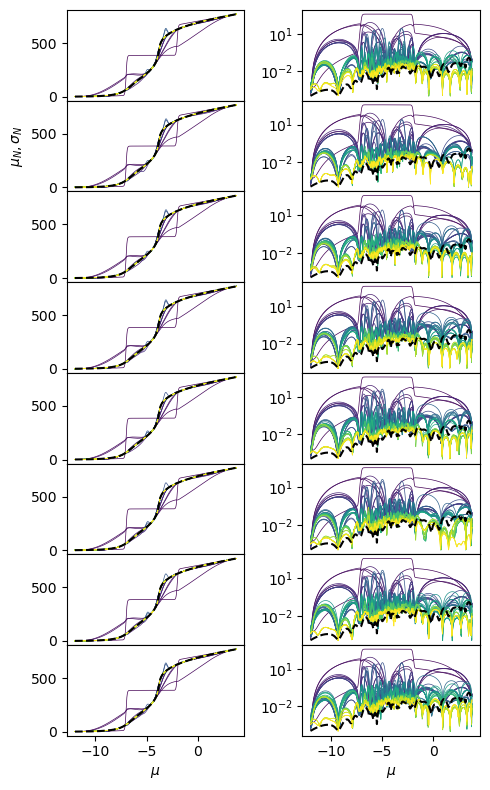

In [38]:
#Plot curves over each iteration for each run
#With uncertainty in second column
fig, ax = plt.subplots(len(train_info_cp_alm), 2, sharex=True, sharey='col', figsize=(5.0, 1.0*len(train_info_cp_alm)))

for i, t_info in enumerate(train_info_cp_alm):
    this_means = t_info['pred_mu']
    this_stds = t_info['pred_std']
    this_alphas = t_info['alpha']
    this_alpha_grid = np.linspace(t_info['alpha'].min(), t_info['alpha'].max(), this_means.shape[1])
    this_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_means.shape[0]))
    for j in range(this_means.shape[0]):
        ax[i, 0].plot(this_alpha_grid, this_means[j, :], color=this_colors[j], linewidth=0.5)
        ax[i, 1].plot(this_alpha_grid, this_stds[j, :], color=this_colors[j], linewidth=0.5)
    ax[i, 0].plot(mu_plot, ads_vals[:, 0], 'k--')
    ax[i, 1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1, 0].set_xlabel(r'$\mu$')
ax[-1, 1].set_xlabel(r'$\mu$')
ax[1, 0].set_ylabel(r'$\mu_N , \sigma_N$')

ax[0, 1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

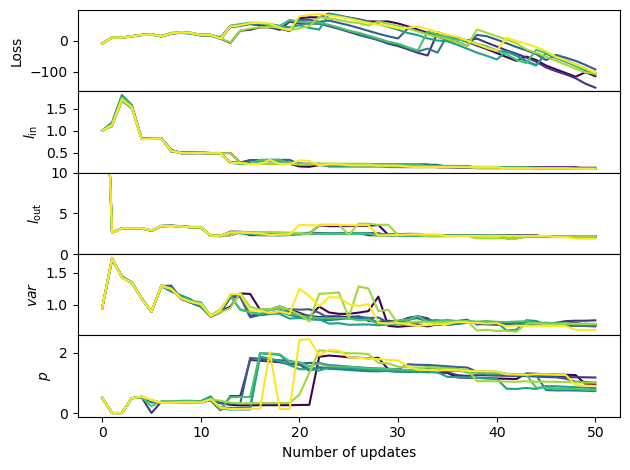

In [39]:
#Plot model parameters and loss over update iterations
fig, ax = plt.subplots(5, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_cp_alm)))

for i, t_info in enumerate(train_info_cp_alm):
    ax[0].plot(t_info['loss'], color=run_colors[i])
    this_params = t_info['params']
    for j in range(this_params.shape[1]):
        ax[j+1].plot(this_params[:, j], color=run_colors[i])

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'Loss')
ax[1].set_ylabel(r'$l_\mathrm{in}$')
ax[2].set_ylabel(r'$l_\mathrm{out}$')
ax[3].set_ylabel(r'$var$')
ax[4].set_ylabel(r'$p$')

# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
ax[2].set_ylim((0.0, 10.0))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

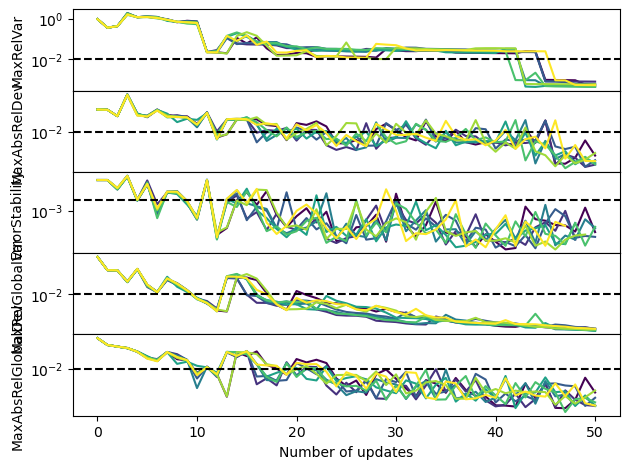

In [40]:
#Plot stopping criteria metrics over update iterations
fig, ax = plt.subplots(5, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_cp_alm)))

for i, t_info in enumerate(train_info_cp_alm):
    ax[0].plot(t_info['MaxRelVar'], color=run_colors[i])
    ax[1].plot(t_info['MaxAbsRelDev'], color=run_colors[i])
    ax[2].plot(t_info['ErrorStability'], color=run_colors[i])
    ax[3].plot(t_info['MaxRelGlobalVar'], color=run_colors[i])
    ax[4].plot(t_info['MaxAbsRelGlobalDeviation'], color=run_colors[i])

for a in ax:
    a.axhline(1e-02, color='k', linestyle='--')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'MaxRelVar')
ax[1].set_ylabel(r'MaxAbsRelDev')
ax[2].set_ylabel(r'ErrorStability')
ax[3].set_ylabel(r'MaxRelGlobalVar')
ax[4].set_ylabel(r'MaxAbsRelGlobalDev')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Space filling

In [41]:
#Collect training information
train_info_cp_space = []
for rdir in run_dirs[:8]:
    try:
        train_info_cp_space.append(np.load('%s/changepoints_space/active_history.npz'%rdir))
    except IOError:
        print("File not found in directory %s"%rdir)

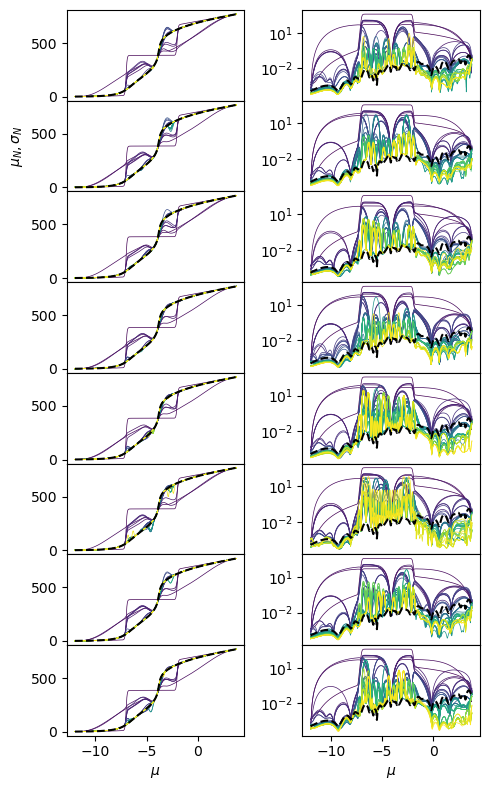

In [42]:
#Plot curves over each iteration for each run
#With uncertainty in second column
fig, ax = plt.subplots(len(train_info_cp_space), 2, sharex=True, sharey='col', figsize=(5.0, 1.0*len(train_info_cp_space)))

for i, t_info in enumerate(train_info_cp_space):
    this_means = t_info['pred_mu']
    this_stds = t_info['pred_std']
    this_alphas = t_info['alpha']
    this_alpha_grid = np.linspace(t_info['alpha'].min(), t_info['alpha'].max(), this_means.shape[1])
    this_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_means.shape[0]))
    for j in range(this_means.shape[0]):
        ax[i, 0].plot(this_alpha_grid, this_means[j, :], color=this_colors[j], linewidth=0.5)
        ax[i, 1].plot(this_alpha_grid, this_stds[j, :], color=this_colors[j], linewidth=0.5)
    ax[i, 0].plot(mu_plot, ads_vals[:, 0], 'k--')
    ax[i, 1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1, 0].set_xlabel(r'$\mu$')
ax[-1, 1].set_xlabel(r'$\mu$')
ax[1, 0].set_ylabel(r'$\mu_N , \sigma_N$')

ax[0, 1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

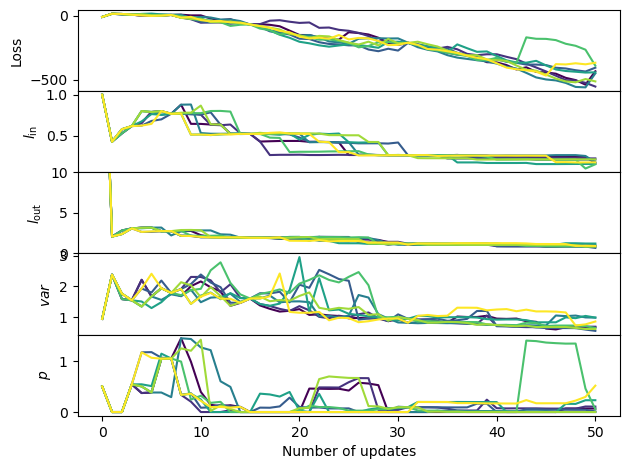

In [43]:
#Plot model parameters and loss over update iterations
fig, ax = plt.subplots(5, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_cp_space)))

for i, t_info in enumerate(train_info_cp_space):
    ax[0].plot(t_info['loss'], color=run_colors[i])
    this_params = t_info['params']
    for j in range(this_params.shape[1]):
        ax[j+1].plot(this_params[:, j], color=run_colors[i])

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'Loss')
ax[1].set_ylabel(r'$l_\mathrm{in}$')
ax[2].set_ylabel(r'$l_\mathrm{out}$')
ax[3].set_ylabel(r'$var$')
ax[4].set_ylabel(r'$p$')

# ax[0].set_yscale('log')
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
ax[2].set_ylim((0.0, 10.0))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

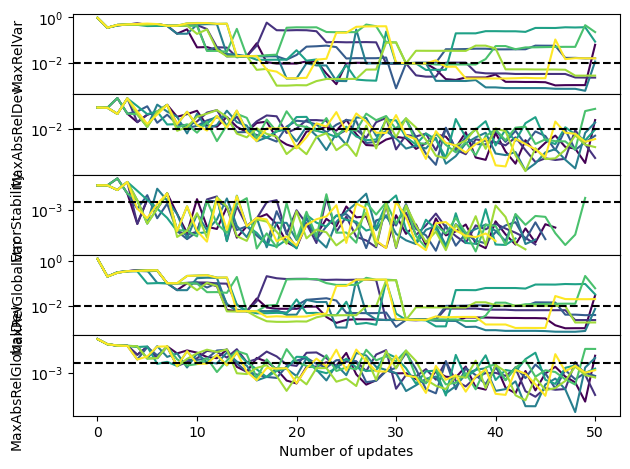

In [44]:
#Plot stopping criteria metrics over update iterations
fig, ax = plt.subplots(5, sharex=True, sharey=False)

run_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(train_info_cp_space)))

for i, t_info in enumerate(train_info_cp_space):
    ax[0].plot(t_info['MaxRelVar'], color=run_colors[i])
    ax[1].plot(t_info['MaxAbsRelDev'], color=run_colors[i])
    ax[2].plot(t_info['ErrorStability'], color=run_colors[i])
    ax[3].plot(t_info['MaxRelGlobalVar'], color=run_colors[i])
    ax[4].plot(t_info['MaxAbsRelGlobalDeviation'], color=run_colors[i])

for a in ax:
    a.axhline(1e-02, color='k', linestyle='--')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'MaxRelVar')
ax[1].set_ylabel(r'MaxAbsRelDev')
ax[2].set_ylabel(r'ErrorStability')
ax[3].set_ylabel(r'MaxRelGlobalVar')
ax[4].set_ylabel(r'MaxAbsRelGlobalDev')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Comparison

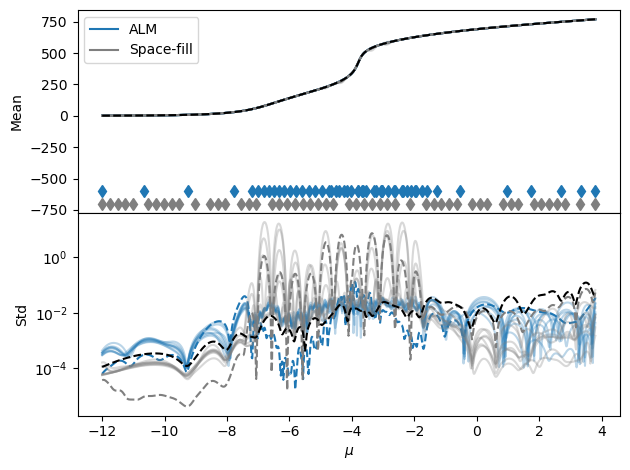

In [48]:
#All final models (values, not derivatives)
fig, ax = plt.subplots(2, sharex=True)

train_colors = ['tab:blue', 'tab:gray']
train_labels = ['ALM', 'Space-fill']

for i, t_info_list in enumerate([train_info_cp_alm, train_info_cp_space]):
    this_mu = np.array([t_info['pred_mu'][-1, ..., 0] for t_info in t_info_list])
    this_avg_mu = np.average(this_mu, axis=0)
    this_std_mu = np.std(this_mu, axis=0)
    this_std = np.array([t_info['pred_std'][-1, ..., 0] for t_info in t_info_list])
    this_alpha = t_info_list[0]['alpha']
    this_alpha_grid = np.linspace(this_alpha.min(), this_alpha.max(), this_mu.shape[1])
    ax[0].plot(this_alpha_grid, this_avg_mu, color=train_colors[i], label=train_labels[i])
    ax[1].plot(this_alpha_grid, this_std_mu, color=train_colors[i], linestyle='--')
    ax[0].plot(this_alpha_grid, this_mu.T, color=train_colors[i], alpha=0.3)
    ax[1].plot(this_alpha_grid, this_std.T, color=train_colors[i], alpha=0.3)
    
    ax[0].plot(t_info_list[0]['alpha'], (-600-i*100)*np.ones_like(t_info_list[0]['alpha']),
               marker='d', color=train_colors[i], linestyle='')

ax[0].legend()

ax[0].plot(mu_plot, ads_vals[:, 0], 'k--')
ax[1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1].set_xlabel(r'$\mu$')

ax[0].set_ylabel(r'Mean')
ax[1].set_ylabel(r'Std')

ax[1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

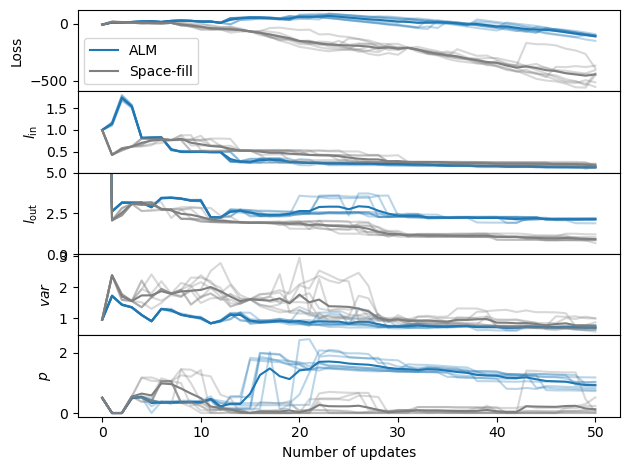

In [49]:
#Comparing losses and parameters
fig, ax = plt.subplots(5, sharex=True, sharey=False)

train_colors = ['tab:blue', 'tab:gray']
train_labels = ['ALM', 'Space-fill']

for i, t_info_list in enumerate([train_info_cp_alm, train_info_cp_space]):
    this_loss = np.array([t_info['loss'] for t_info in t_info_list])
    this_avg_loss = np.average(this_loss, axis=0)
    this_std_loss = np.std(this_loss, axis=0)
    ax[0].plot(this_avg_loss, color=train_colors[i], label=train_labels[i])
    ax[0].plot(this_loss.T, color=train_colors[i], alpha=0.3)
#     ax[0].fill_between(np.arange(this_avg_loss.shape[0]),
#                        this_avg_loss-2.0*this_std_loss,
#                        this_avg_loss+2.0*this_std_loss,
#                        color=train_colors[i], alpha=0.3)
    this_params = np.array([t_info['params'] for t_info in t_info_list])
    for j in range(this_params.shape[-1]):
        this_avg_param = np.average(this_params[:, :, j], axis=0)
        this_std_param = np.std(this_params[:, :, j], axis=0)
        ax[j+1].plot(this_avg_param, color=train_colors[i])
        ax[j+1].plot(this_params[:, :, j].T, color=train_colors[i], alpha=0.3)
#         ax[j+1].fill_between(np.arange(this_avg_param.shape[0]),
#                              this_avg_param-2.0*this_std_param,
#                              this_avg_param+2.0*this_std_param,
#                              color=train_colors[i], alpha=0.3)

ax[0].legend()

ax[-1].set_xlabel(r'Number of updates')
ax[0].set_ylabel(r'Loss')
ax[1].set_ylabel(r'$l_\mathrm{in}$')
ax[2].set_ylabel(r'$l_\mathrm{out}$')
ax[3].set_ylabel(r'$var$')
ax[4].set_ylabel(r'$p$')

# ax[0].set_yscale('log')
# ax[0].set_ylim((1e-01, 2e+03))
# ax[1].set_ylim((0.0, 2.0))
# ax[2].set_yscale('log')
ax[2].set_ylim((0.0, 5.0))
# ax[3].set_ylim((0.0, 3.0))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

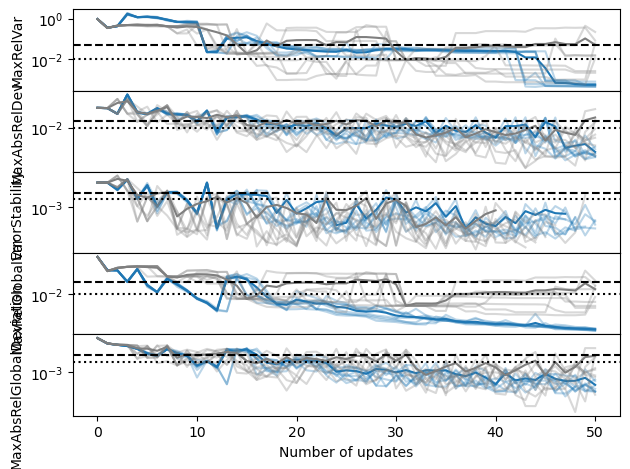

In [50]:
#Plot stopping criteria metrics over update iterations
metric_names = ['MaxRelVar', 'MaxAbsRelDev', 'ErrorStability', 'MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

fig, ax = plt.subplots(len(metric_names), sharex=True, sharey=False)

train_colors = ['tab:blue', 'tab:gray']
train_labels = ['ALM', 'Space-fill']

for i, t_info_list in enumerate([train_info_cp_alm, train_info_cp_space]):
    for j, key in enumerate(metric_names):
        this_metric = np.array([t_info[key] for t_info in t_info_list])
        this_avg_metric = np.average(this_metric, axis=0)
        this_std_metric = np.std(this_metric, axis=0)
        ax[j].plot(this_avg_metric, color=train_colors[i], label=train_labels[i])
        ax[j].plot(this_metric.T, color=train_colors[i], alpha=0.3)

for a in ax:
    a.axhline(5e-02, color='k', linestyle='--')
    a.axhline(1e-02, color='k', linestyle=':')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
for j, key in enumerate(metric_names):
    ax[j].set_ylabel(key)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

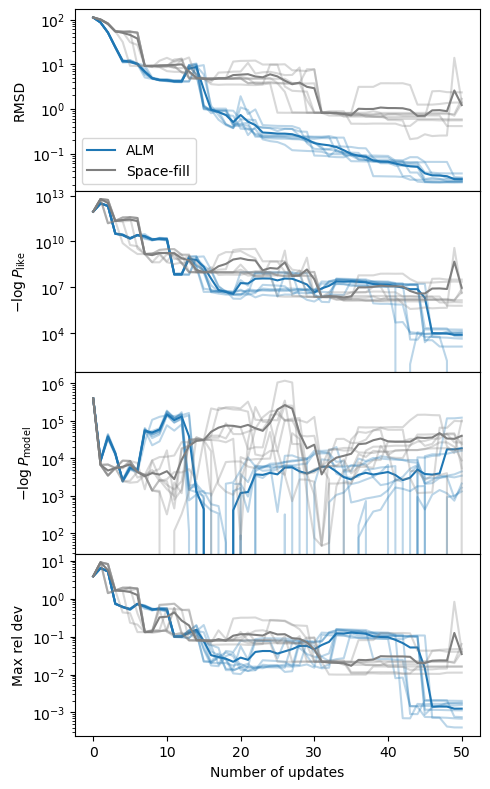

In [51]:
#Real test is distance from ground truth
#Have intentionally set mu_plot so that will be same as values used to evaluate GP models in training histories
#So can compare distance to ground truth versus update iteration
fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(5.0, 2.0*4))

train_colors = ['tab:blue', 'tab:gray']
train_labels = ['ALM', 'Space-fill']

for i, t_info_list in enumerate([train_info_cp_alm, train_info_cp_space]):
    this_mean = np.array([t_info['pred_mu'][..., 0] for t_info in t_info_list])
    this_std = np.array([t_info['pred_std'][..., 0] for t_info in t_info_list])
    this_rmsd = np.sqrt(np.average((this_mean - ads_vals[:, 0])**2, axis=-1))
    this_gt_logprob = np.sum(0.5*((this_mean - ads_vals[:, 0])/ads_vals[:, 1])**2 + np.log(ads_vals[:, 1]), axis=-1)
    #Below log probability is not strictly correct... under posterior, model predictions NOT independent
    #So need full covariance, but not saved as part of history and do not have data list, either, to rebuild GP
    this_model_logprob = np.sum(0.5*((ads_vals[:, 0] - this_mean)/this_std)**2 + np.log(this_std), axis=-1)
    this_max_rel_dev = np.max(abs(this_mean - ads_vals[:, 0]) / abs(ads_vals[:, 0]), axis=-1)
    ax[0].plot(np.average(this_rmsd, axis=0), color=train_colors[i], label=train_labels[i])
    ax[0].plot(this_rmsd.T, color=train_colors[i], alpha=0.3)
    ax[1].plot(np.average(this_gt_logprob, axis=0), color=train_colors[i], label=train_labels[i])
    ax[1].plot(this_gt_logprob.T, color=train_colors[i], alpha=0.3)
    ax[2].plot(np.average(this_model_logprob, axis=0), color=train_colors[i], label=train_labels[i])
    ax[2].plot(this_model_logprob.T, color=train_colors[i], alpha=0.3)
    ax[3].plot(np.average(this_max_rel_dev, axis=0), color=train_colors[i], label=train_labels[i])
    ax[3].plot(this_max_rel_dev.T, color=train_colors[i], alpha=0.3)

ax[0].legend()

ax[-1].set_xlabel('Number of updates')
ax[0].set_ylabel('RMSD')
ax[1].set_ylabel(r'$-\log P_\mathrm{like}$')
ax[2].set_ylabel(r'$-\log P_\mathrm{model}$')
ax[3].set_ylabel(r'Max rel dev')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Effect of adding change points

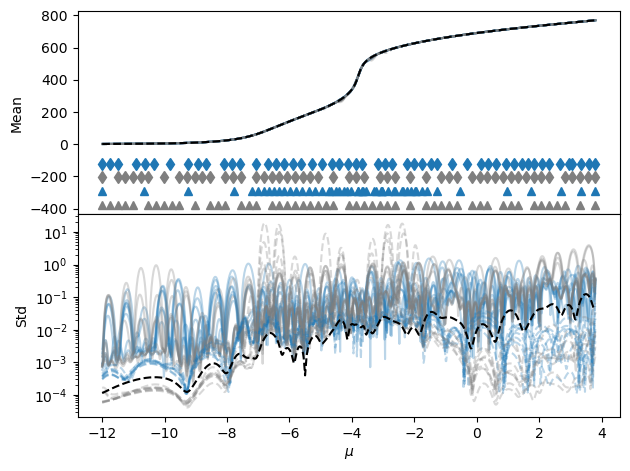

In [52]:
#All final models (values, not derivatives)
fig, ax = plt.subplots(2, sharex=True)

train_colors = ['tab:blue', 'tab:gray', 'tab:blue', 'tab:gray']
train_labels = ['ALM', 'Space-fill', 'ALM w/ CP', 'Space-fill w/ CP']
line_styles = ['-', '-', '--', '--']
marker_styles = ['d', 'd', '^', '^']

alpha_vals_list = []
for i, t_info_list in enumerate([train_info_alm, train_info_space, train_info_cp_alm, train_info_cp_space]):
    this_mu = np.array([t_info['pred_mu'][-1, ..., 0] for t_info in t_info_list])
    this_avg_mu = np.average(this_mu, axis=0)
    this_std = np.array([t_info['pred_std'][-1, ..., 0] for t_info in t_info_list])
    this_alpha = t_info_list[0]['alpha']
    this_alpha_grid = np.linspace(this_alpha.min(), this_alpha.max(), this_mu.shape[1])
    ax[0].plot(this_alpha_grid, this_mu.T, color=train_colors[i], linestyle=line_styles[i], alpha=0.3)
    ax[1].plot(this_alpha_grid, this_std.T, color=train_colors[i], linestyle=line_styles[i], alpha=0.3)
    alpha_vals_list.append(this_alpha)
    
#After plotting ALL other curves, plot alphas based on automatic y limits
y_lims = ax[0].get_ylim()
for i, this_alpha in enumerate(alpha_vals_list):
    ax[0].plot(this_alpha, (y_lims[0]-(i+1)*0.10*(y_lims[1] - y_lims[0]))*np.ones_like(this_alpha),
               marker=marker_styles[i], color=train_colors[i], linestyle='')

#ax[0].legend()

ax[0].plot(mu_plot, ads_vals[:, 0], 'k--')
ax[1].plot(mu_plot, ads_vals[:, 1], 'k--')

ax[-1].set_xlabel(r'$\mu$')

ax[0].set_ylabel(r'Mean')
ax[1].set_ylabel(r'Std')

ax[1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

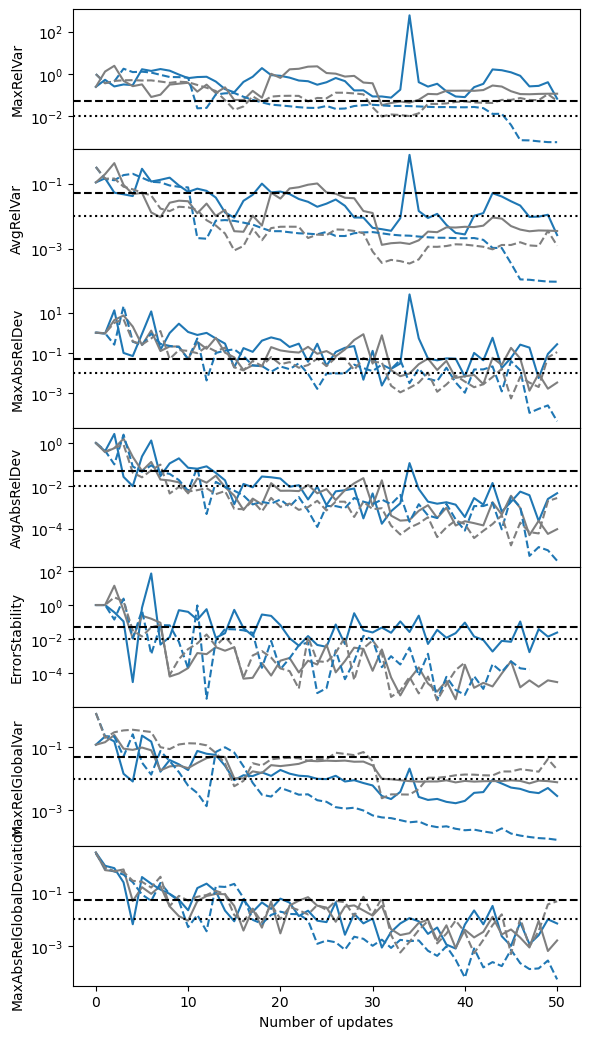

In [53]:
#Plot stopping criteria metrics over update iterations
metric_names = ['MaxRelVar', 'AvgRelVar', 'MaxAbsRelDev', 'AvgAbsRelDev', 'ErrorStability',
                'MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

fig, ax = plt.subplots(len(metric_names), sharex=True, sharey=False, figsize=(6, 1.5*len(metric_names)))

train_colors = ['tab:blue', 'tab:gray', 'tab:blue', 'tab:gray']
train_labels = ['ALM', 'Space-fill', 'ALM w/ CP', 'Space-fill w/ CP']
line_styles = ['-', '-', '--', '--']

for i, t_info_list in enumerate([train_info_alm, train_info_space, train_info_cp_alm, train_info_cp_space]):
    for j, key in enumerate(metric_names):
        this_metric = np.array([t_info[key] for t_info in t_info_list])
        this_avg_metric = np.average(this_metric, axis=0)
        this_std_metric = np.std(this_metric, axis=0)
        ax[j].plot(this_avg_metric, color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])

for a in ax:
    a.axhline(5e-02, color='k', linestyle='--')
    a.axhline(1e-02, color='k', linestyle=':')
    a.set_yscale('log')

ax[-1].set_xlabel(r'Number of updates')
for j, key in enumerate(metric_names):
    ax[j].set_ylabel(key)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

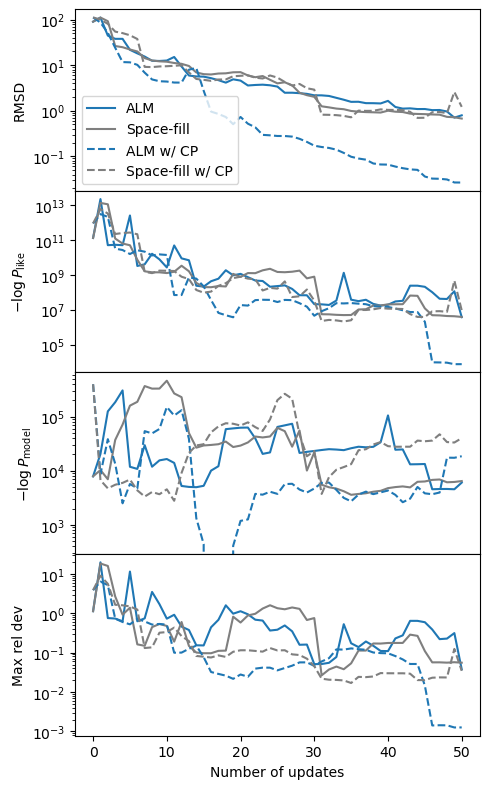

In [54]:
#Real test is distance from ground truth
#Have intentionally set mu_plot so that will be same as values used to evaluate GP models in training histories
#So can compare distance to ground truth versus update iteration
fig, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(5.0, 2.0*4))

train_colors = ['tab:blue', 'tab:gray', 'tab:blue', 'tab:gray']
train_labels = ['ALM', 'Space-fill', 'ALM w/ CP', 'Space-fill w/ CP']
line_styles = ['-', '-', '--', '--']

for i, t_info_list in enumerate([train_info_alm, train_info_space, train_info_cp_alm, train_info_cp_space]):
    this_mean = np.array([t_info['pred_mu'][..., 0] for t_info in t_info_list])
    this_std = np.array([t_info['pred_std'][..., 0] for t_info in t_info_list])
    this_rmsd = np.sqrt(np.average((this_mean - ads_vals[:, 0])**2, axis=-1))
    this_gt_logprob = np.sum(0.5*((this_mean - ads_vals[:, 0])/ads_vals[:, 1])**2 + np.log(ads_vals[:, 1]), axis=-1)
    #Below log probability is not strictly correct... under posterior, model predictions NOT independent
    #So need full covariance, but not saved as part of history and do not have data list, either, to rebuild GP
    this_model_logprob = np.sum(0.5*((ads_vals[:, 0] - this_mean)/this_std)**2 + np.log(this_std), axis=-1)
    this_max_rel_dev = np.max(abs(this_mean - ads_vals[:, 0]) / abs(ads_vals[:, 0]), axis=-1)
    ax[0].plot(np.average(this_rmsd, axis=0), color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])
    ax[1].plot(np.average(this_gt_logprob, axis=0), color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])
    ax[2].plot(np.average(this_model_logprob, axis=0), color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])
    ax[3].plot(np.average(this_max_rel_dev, axis=0), color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])

ax[0].legend()

ax[-1].set_xlabel('Number of updates')
ax[0].set_ylabel('RMSD')
ax[1].set_ylabel(r'$-\log P_\mathrm{like}$')
ax[2].set_ylabel(r'$-\log P_\mathrm{model}$')
ax[3].set_ylabel(r'Max rel dev')

ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

## Nice Figures

In [7]:
%matplotlib inline

#Load all the data that we'll need
#Identify directory where data is held
base_dir = os.path.expanduser('~/GPR_Extrapolation/Adsorption')

#And all run directories
run_dirs = glob.glob('%s/run*'%base_dir)
run_dirs.sort()
print(run_dirs)

#Define methods used for updates/models
method_names = ['alm', 'random', 'space_fill', 'changepoints_alm', 'changepoints_space']

#Collect training information
train_info_dict = {}
for m_name in method_names:
    train_info_dict[m_name] = []
    for rdir in run_dirs:
        try:
            train_info_dict[m_name].append(np.load('%s/%s/active_history.npz'%(rdir, m_name)))
        except IOError:
            print("File not found in directory %s"%rdir)


['/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run1', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run10', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run11', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run12', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run13', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run14', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run15', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run16', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run17', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run18', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run19', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run2', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run20', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run21', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run22', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run23', '/Users/jacobmonroe/GPR_Extrapolation/Adsorption/run24', '/Users/jacobmonroe/GPR_Extrapol

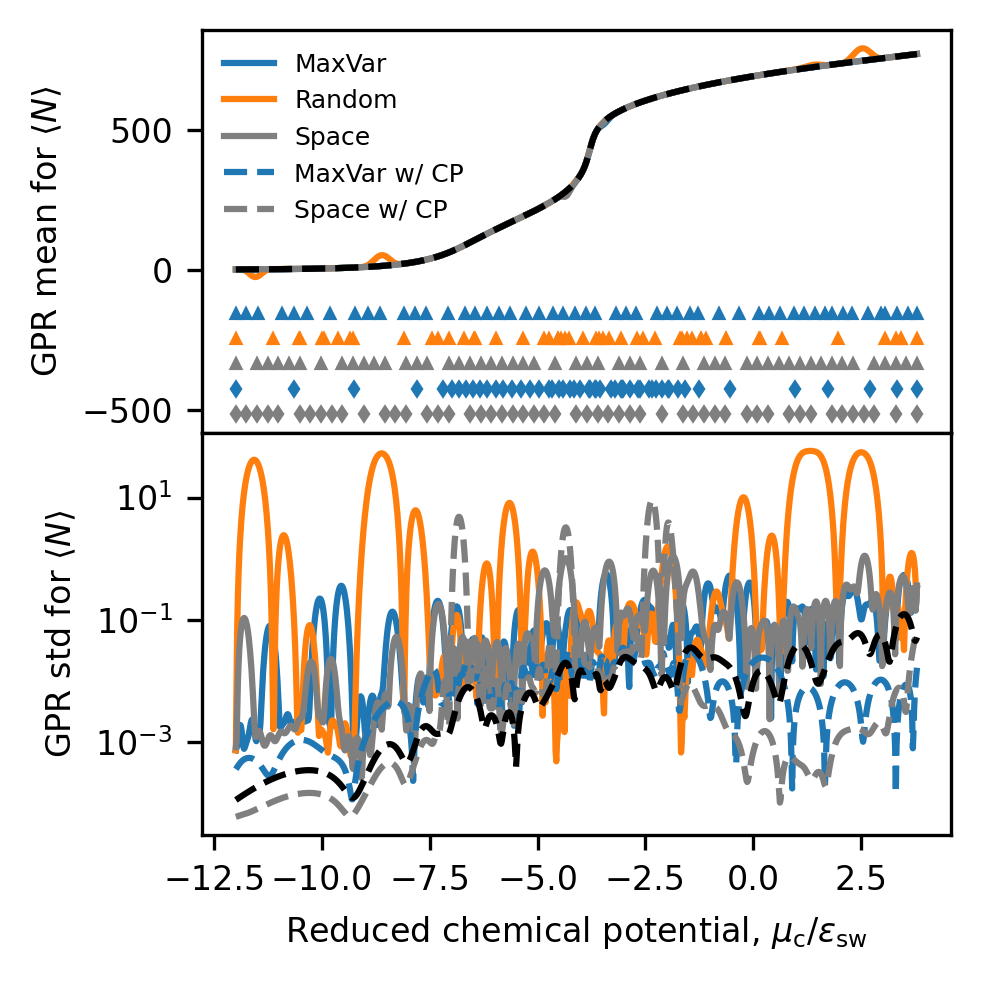

In [8]:
#All final models (values, not derivatives)
fig, ax = plt.subplots(2, sharex=True, figsize=(3.37, 3.37), dpi=300)

train_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:blue', 'tab:gray']
train_labels = ['MaxVar', 'Random', 'Space', 'MaxVar w/ CP', 'Space w/ CP']
line_styles = ['-', '-', '-', '--', '--']
marker_styles = ['^', '^', '^', 'd', 'd']

alpha_vals_list = []
for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    this_mu = np.array([t_info['pred_mu'][-1, :] for t_info in t_info_list])
    this_avg_mu = np.average(this_mu, axis=0)
    this_std = np.array([t_info['pred_std'][-1, :] for t_info in t_info_list])
    this_alpha = t_info_list[0]['alpha']
    this_alpha_grid = np.linspace(this_alpha.min(), this_alpha.max(), this_mu.shape[1])
    ax[0].plot(this_alpha_grid, this_mu[0, :], label=train_labels[i],
               color=train_colors[i], linestyle=line_styles[i])#, alpha=0.3)
    ax[1].plot(this_alpha_grid, this_std[0, :], label=train_labels[i],
               color=train_colors[i], linestyle=line_styles[i])#, alpha=0.3)
    alpha_vals_list.append(this_alpha)
    
#After plotting ALL other curves, plot alphas based on automatic y limits
y_lims = ax[0].get_ylim()
for i, this_alpha in enumerate(alpha_vals_list):
    ax[0].plot(this_alpha, (y_lims[0]-(i+1)*0.10*(y_lims[1] - y_lims[0]))*np.ones_like(this_alpha),
               marker=marker_styles[i], color=train_colors[i], linestyle='', markersize=2)

ax[0].legend(frameon=False, fontsize=6, loc=2)

ax[0].plot(mu_plot, ads_vals[:, 0], 'k--')
ax[1].plot(mu_plot, ads_vals[:, 1], 'k--')

for a in ax:
    a.yaxis.set_major_locator(MaxNLocator(prune='both', nbins=3))
    a.tick_params(axis='both', labelsize=8)

ax[-1].set_xlabel(r'Reduced chemical potential, $\mu_\mathrm{c} / \epsilon_\mathrm{sw}$', fontsize=8)

ax[0].set_ylabel(r'GPR mean for $\langle N \rangle$', fontsize=8)
ax[1].set_ylabel(r'GPR std for $\langle N \rangle$', fontsize=8)

ax[1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

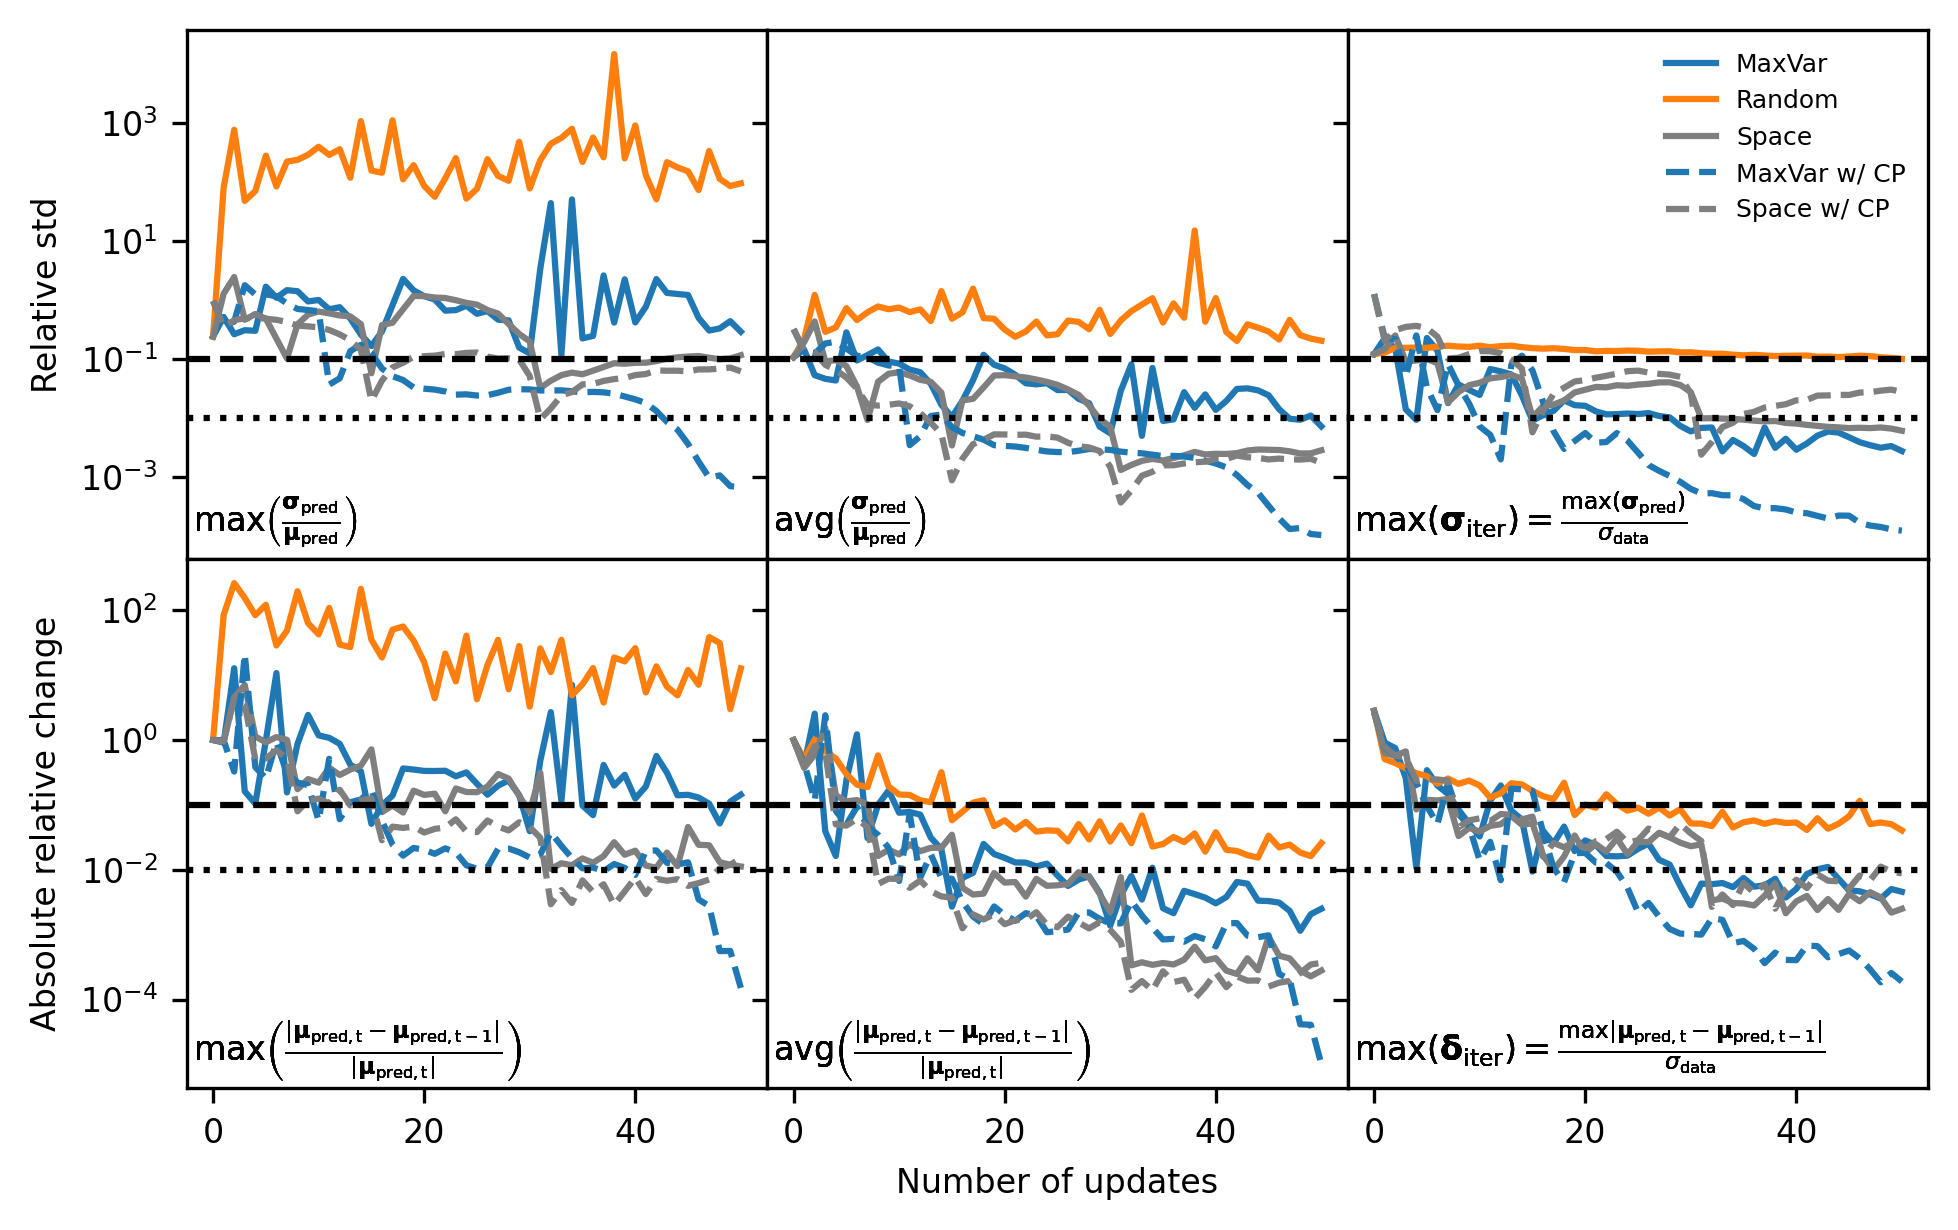

In [12]:
#Plot stopping criteria metrics over update iterations
metric_names = ['MaxRelVar', 'AvgRelVar', 'MaxRelGlobalVar',
                'MaxAbsRelDev', 'AvgAbsRelDev', 'MaxAbsRelGlobalDeviation']
metric_labels = [r'$\mathrm{max} \left( \frac{\mathbf{\sigma}_\mathrm{pred}}{\mathbf{\mu}_\mathrm{pred}} \right)$',
                 r'$\mathrm{avg} \left( \frac{\mathbf{\sigma}_\mathrm{pred}}{\mathbf{\mu}_\mathrm{pred}} \right)$',
                 r'$\mathrm{max} \left( \mathbf{\sigma}_\mathrm{iter} \right) = \frac{ \mathrm{max} \left( \mathbf{\sigma}_\mathrm{pred} \right)}{\sigma_\mathrm{data}}$',
                 r'$\mathrm{max} \left( \frac{\left| \mathbf{\mu}_\mathrm{pred, t} - \mathbf{\mu}_\mathrm{pred, t-1} \right|}{\left| \mathbf{\mu}_\mathrm{pred, t} \right|} \right)$',
                 r'$\mathrm{avg} \left( \frac{\left| \mathbf{\mu}_\mathrm{pred, t} - \mathbf{\mu}_\mathrm{pred, t-1} \right|}{\left| \mathbf{\mu}_\mathrm{pred, t} \right|} \right)$',
                 r'$\mathrm{max} \left( \mathbf{\delta}_\mathrm{iter} \right) = \frac{ \mathrm{max} \left| \mathbf{\mu}_\mathrm{pred, t} - \mathbf{\mu}_\mathrm{pred, t-1} \right|}{\sigma_\mathrm{data}}$']

fig, ax = plt.subplots(2, 3, sharex=True, sharey='row', figsize=(6.69, 4.2), dpi=300)

train_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:blue', 'tab:gray']
train_labels = ['MaxVar', 'Random', 'Space', 'MaxVar w/ CP', 'Space w/ CP']
line_styles = ['-', '-', '-', '--', '--']

dat_std_y = np.std(train_info_dict['space_fill'][0]['pred_mu'][-1, ...], axis=0)

for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    for j, key in enumerate(metric_names):
        this_metric = np.array([t_info[key] for t_info in t_info_list])
        this_avg_metric = np.average(this_metric, axis=0)
        ax[j//3, j%3].plot(this_avg_metric, color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])#, alpha=0.3)
        ax[j//3, j%3].annotate(metric_labels[j], xy=(0.01, 0.05), xycoords='axes fraction', fontsize=8)
        ax[j//3, j%3].tick_params(axis='both', labelsize=8)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].axhline(10e-02, color='k', linestyle='--')
        ax[i, j].axhline(1e-02, color='k', linestyle=':')
        ax[i, j].set_yscale('log')
#         ax[i, j].annotate(metric_names[i*3 + j], xy=(0.05, 0.85), xycoords='axes fraction')

# ax[-1, 0].set_xlabel(r'Number of updates')
ax[-1, 1].set_xlabel(r'Number of updates', fontsize=8)

ax[0, 0].set_ylabel(r'Relative std', fontsize=8)
ax[1, 0].set_ylabel(r'Absolute relative change', fontsize=8)

# ax[0, 0].set_title(r'Max local')
# ax[0, 1].set_title(r'Avg local')
# ax[0, 2].set_title(r'Max global')

ax[0, 2].legend(fontsize=6, frameon=False)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()

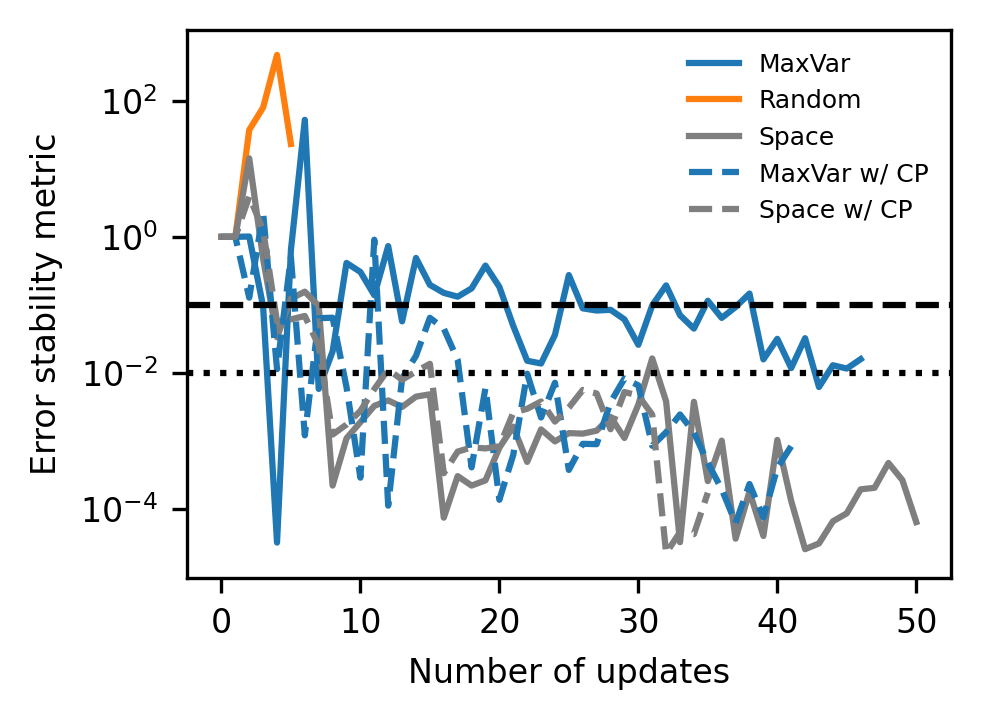

In [13]:
#Plot error stability metric versus iterations for SI
fig, ax = plt.subplots(figsize=(3.37, 2.5), dpi=300)

train_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:blue', 'tab:gray']
train_labels = ['MaxVar', 'Random', 'Space', 'MaxVar w/ CP', 'Space w/ CP']
line_styles = ['-', '-', '-', '--', '--']

for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    this_metric = np.array([t_info['ErrorStability'] for t_info in t_info_list])
    this_avg_metric = np.average(this_metric, axis=0)
    ax.plot(this_avg_metric, color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])#, alpha=0.3)

ax.axhline(10e-02, color='k', linestyle='--')
ax.axhline(1e-02, color='k', linestyle=':')
ax.set_yscale('log')

ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel(r'Number of updates', fontsize=8)

ax.set_ylabel(r'Error stability metric', fontsize=8)

ax.legend(fontsize=6, frameon=False)

fig.tight_layout()

plt.show()

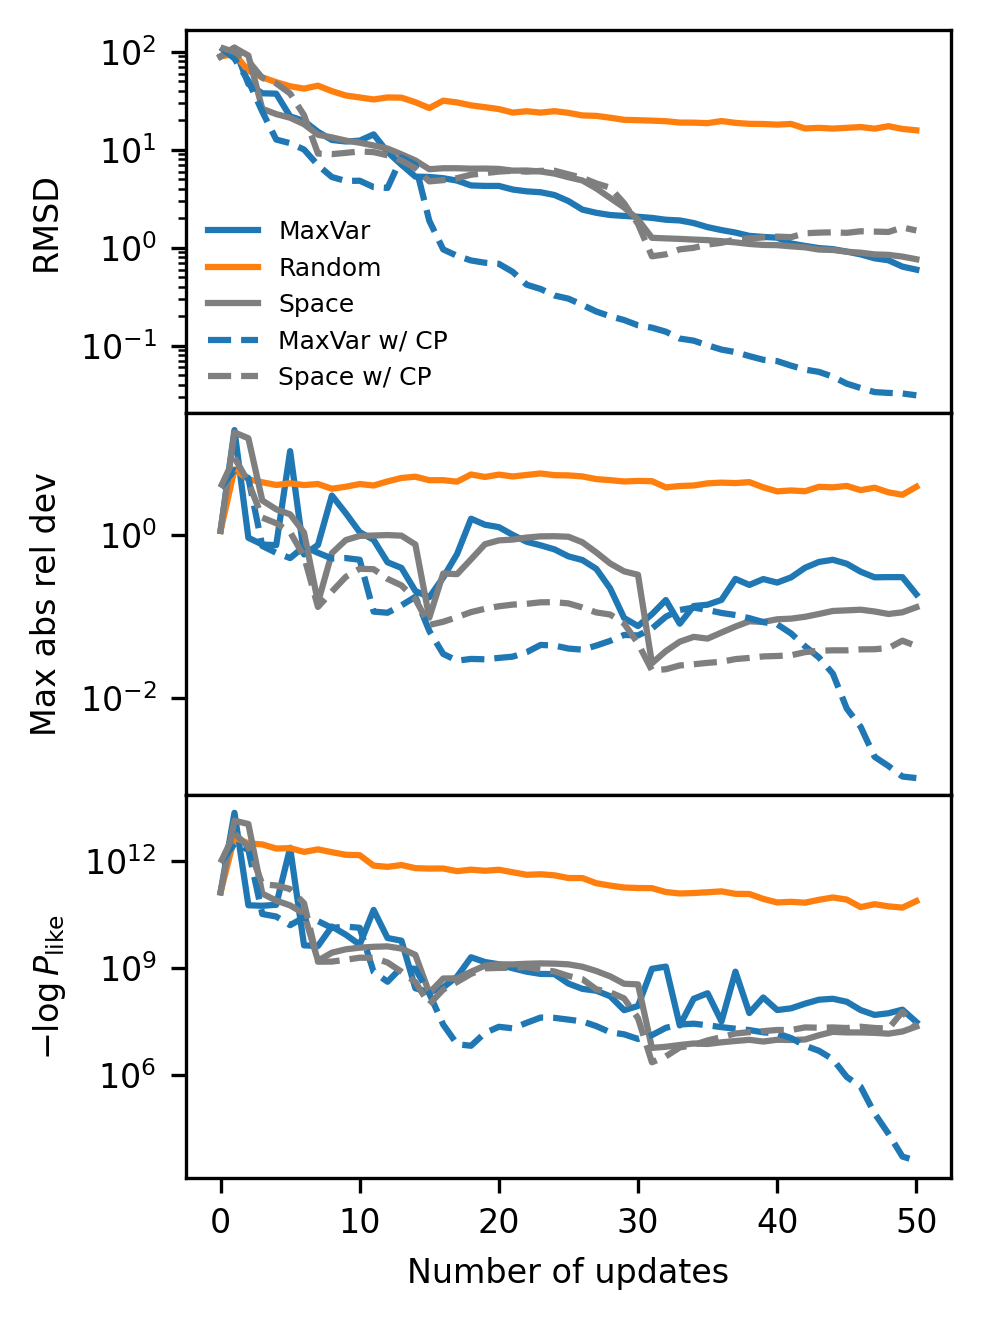

In [14]:
#Real test is distance from ground truth
#Have intentionally set mu_plot so that will be same as values used to evaluate GP models in training histories
#So can compare distance to ground truth versus update iteration
fig, ax = plt.subplots(3, sharex=True, sharey=False, figsize=(3.37, 1.5*3), dpi=300)

train_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:blue', 'tab:gray']
train_labels = ['MaxVar', 'Random', 'Space', 'MaxVar w/ CP', 'Space w/ CP']
line_styles = ['-', '-', '-', '--', '--']

for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    this_mean = np.array([t_info['pred_mu'][..., 0] for t_info in t_info_list])
    this_std = np.array([t_info['pred_std'][..., 0] for t_info in t_info_list])
    this_max_rel_dev = np.max(abs(this_mean - ads_vals[:, 0]) / abs(ads_vals[:, 0]), axis=-1)
    this_rmsd = np.sqrt(np.average(((this_mean - ads_vals[:, 0]))**2, axis=-1))
    this_gt_logprob = np.sum(0.5*((this_mean - ads_vals[:, 0])/ads_vals[:, 1])**2 + np.log(ads_vals[:, 1]), axis=-1)
    ax[0].plot(np.average(this_rmsd, axis=0), color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])
    ax[1].plot(np.average(this_max_rel_dev, axis=0), color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])
    ax[2].plot(np.average(this_gt_logprob, axis=0), color=train_colors[i], linestyle=line_styles[i], label=train_labels[i])
#     ax[0].plot(this_max_rel_dev.T, color=train_colors[i], linestyle=line_styles[i], label=train_labels[i], alpha=0.3)
#     ax[1].plot(this_rmsd.T, color=train_colors[i], linestyle=line_styles[i], label=train_labels[i], alpha=0.3)
#     ax[2].plot(this_gt_logprob.T, color=train_colors[i], linestyle=line_styles[i], label=train_labels[i], alpha=0.3)
    
ax[0].legend(fontsize=6, frameon=False)

ax[-1].set_xlabel('Number of updates', fontsize=8)
ax[0].set_ylabel('RMSD', fontsize=8)
ax[1].set_ylabel(r'Max abs rel dev', fontsize=8)
# ax[1].set_ylabel(r'$max \left( \left| \mathbf{\mu}_\mathrm{pred} - \mathrm{g.t.} \right| \left| \mathrm{g.t.} \right| \right)$', fontsize=8)
ax[2].set_ylabel(r'$-\log P_\mathrm{like}$', fontsize=8)

for a in ax:
    a.set_yscale('log')
    a.tick_params(axis='both', labelsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()